# Photon-to-axion/dark-photon coupling solver in the case of costant magnetic field and in one halo. 

(SEE THE GENERAL NOTEBOOK FOR A MORE PRECISE TREATMENT OF THE MATTER)

Here we want to solve the photon-to-axion or the photon-to-dark_photon conversion equation in the case we are in an halo, with a certain halo model which gives the function $n_e(r)$ that should be mapped into $n_e(z)$ where $z$ is the axis representing the photon trajectory.

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import odeint, solve_ivp, ode
from scipy.stats import norm
from scipy.interpolate import CubicSpline, interp1d
from scipy.integrate import quad
from scipy.optimize import brentq
from scipy.integrate import cumulative_trapezoid
from scipy.optimize import root_scalar
from scipy.integrate import simpson 
from scipy.interpolate import UnivariateSpline

import math
import astropy.units as u
import astropy.constants as const

from numba import njit #Numba to accelerate the code, solving Just in Time


# Visual settings
%config InlineBackend.figure_format='retina'
%matplotlib inline

if '/Library/TeX/texbin/' not in os.environ["PATH"]:
    os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin/'
    
# Latex font
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import colors
plt.rcParams['figure.figsize'] = [9,7]  # Adjust the size as needed for the plots
from mpl_toolkits.mplot3d import Axes3D




In [2]:
# TO DO LIST

# 1) RISCRIVERE LE QUANTITà DELLE PROBABILITà, SONO UN BORDELLO
# 2) AGGIUSTARE O ADDIRITTURA ELIMINARE ALCUNI PLOT
# 3) IMPLEMENTAZIONE PER PIù PUNTI DI RISONANZA
# 7) Uniformare e fare i test su atol e rtol


In [3]:
#Want to study photon-to-axion or photon-to-dark-photon?

dark_photon = False #Set False if you want to work with axion

In [4]:
####################################
# Natural unit conversions
####################################

#We express all the quantities in eV
GeV = 1 
MeV = 1e-3
keV = 1e-6
eV  = 1e-9
meV = 1e-12 

#Units:
Kg     = 5.609 * 1e35 * eV
meter  = 5.07 * 1e6 * eV**-1
cm     = 1e-2 * meter
Km     = 1e3 * meter
Mpc    = 1.564 * 1e29 * eV**-1
second = 1.5192 * 1e15 * eV**-1
Hz     = 1/second


Gauss  = 1.95 * 1e-2 * eV**2
Joule  = 6.242 * 1e18 * eV  

#Constants
AlphaEM           = 1/137
H_0               = 67.66 * Km/second / Mpc
ElementaryCharge  = np.sqrt(4 * np.pi * AlphaEM);
mass_electron     = 9.109 * 1e-31 * Kg
mass_proton       = 1.672 * 1e-27 * Kg
numerical_density = 1/cm**3


In [5]:
########################################
# Specify parameters of the model
########################################

m_a   = 3e-13 * eV# Axion mass in eV
g_agg = 1e-10 * (GeV)**-1 # Axion photon-coupling in (GeV)^-1
nu    = 145 * 10**9 * Hz # Frequency in Hz 
omega = 2.*np.pi*nu # Angular frequency in Hz

if dark_photon:
    eps   = 1e-5 #photon-dark photon coupling “natural” values in the range 1e-13 - 10e-2  



Here insert a good explanation of the trajectory inside the halo. 



In [6]:
########################################
# Specify the halo model: Battaglia's profile 
########################################

rvir  = 2
rmin  = 1.37 #Defines uniquely the trajectory, it must be higher than r_res 
r_thr = np.logspace(-3, np.log10(rvir), 100000) # radius in Mpc

# Set some parameters (similar to Planck best-fit cosmo)
Omega_b = 0.049
Omega_m = 0.3175
h = 0.6711
H0 = 100*h*u.km/u.s/u.Mpc

z = 0 # redshift
rho_critz = (3*H0**2/(8*np.pi*const.G)).to(u.Msun/u.Mpc**3).value # Msun/Mpc^3


# Halo settings
M200c = 10**13.5 # Msun
R200c = 2 # Mpc


# Geometry of the photon path through the halo
chord_length = 2*np.sqrt(rvir**2 - rmin**2) # Length of the chord crossing the halo (in Mpc)
phii  = np.arcsin(rmin / rvir)  # Impact angle of the trajectory from center (in radians)


def get_ne_battaglia(r, M200c, R200c, z, rho_critz, Omega_b, Omega_m,
                     param_dict=None):
       """
       Computes Battaglia profile as a function of radius. 

       Parameters:
           r: Radius in Mpc
           M200c: M200c in Msun
           R200c: R200c in Mpc
           z: Redshift
           rho_crit_z: Critical density in Msun/Mpc^3
           param_dict: Optional parameters for profile

       Returns:
           Electron number density profile in (1/Mpc**3)

       """

       # Unit conversion
       m_p = 8.411856872862986e-58 # Proton mass in units of Msun
       if param_dict is None:
           # Get Battaglia profile parameters at appropriate redshift
           rho0  = 4000. * (M200c/1e14)**0.29    * (1.+z)**(-0.66)
           alpha = 0.88  * (M200c/1e14)**(-0.03) * (1.+z)**0.19
           beta  = 3.83  * (M200c/1e14)**0.04    * (1.+z)**(-0.025)
           gamma = -0.2

       else:
           rho0  = param_dict['rho0']
           alpha = param_dict['alpha']
           beta  = param_dict['beta']
           gamma = param_dict['gamma']

       x = 2*r/R200c    
       fb = Omega_b/Omega_m
    
       rho_gas = fb*rho_critz*rho0 * (x**gamma) * ((1.+x**alpha)**(-(beta+gamma)/alpha))
       ne_prof = (1+0.76)/(2*m_p)*rho_gas 

       return ne_prof


# Compute profile in M_sun/Mpc**3
n_er = get_ne_battaglia(r_thr, M200c, R200c, z, rho_critz, Omega_b, Omega_m)

#Converting to 1/cm^3 and then to eV^3:
n_er_not_int = (n_er/u.Mpc**3).to(1/u.cm**3).value * numerical_density #first conversion units with astropy


#Interpolating ne
n_er_interp = interp1d(r_thr, n_er_not_int, kind='cubic', bounds_error=False, fill_value="extrapolate") 


In [7]:
########################################
# Specify functions Delta_a and Delta_parallel wrt r
########################################

#Note: we decided to work with \Delta_a and \Delta_\parallel defined without the minus sign. It is totally equivalent and the solution does not change.

def Delta_ar(r):
    """
    Axion mass term
    Delta_a = -m_a^2/(2*omega)
    """
    return m_a**2/(2*omega) 

def m2_gr(r):
    """
    Effective mass of the photon
    acquired by scattering with free electrons
    """
    return   ElementaryCharge**2 * 1/mass_electron * n_er_interp(r) #in eV units 


def Delta_parallelr(r):
    """
    Photon mass term
    Delta_parallel = -m^2_\gamma(z)/2\omega
    """
    return m2_gr(r) /(2* omega)


In [8]:
#########################
# Searching for r_res
#########################

def resonance_condition(r):
    return Delta_parallelr(r) - Delta_ar(r)

# Is there a resonance point?
signs = np.sign(resonance_condition(r_thr))
sign_change_indices = np.where(np.diff(signs))[0]
if len(sign_change_indices) == 0:
    raise RuntimeError("No sign change found: resonance does not occur in this interval.")

#Using the Brent's method to find the root in the interval where the sign changes
i = sign_change_indices[0]
r_low, r_high = r_thr[i], r_thr[i+1]
r_res = brentq(resonance_condition, r_low, r_high)

print(f"Resonance radius found: r_res = {r_res} Mpc")

Resonance radius found: r_res = 1.4521732239327674 Mpc


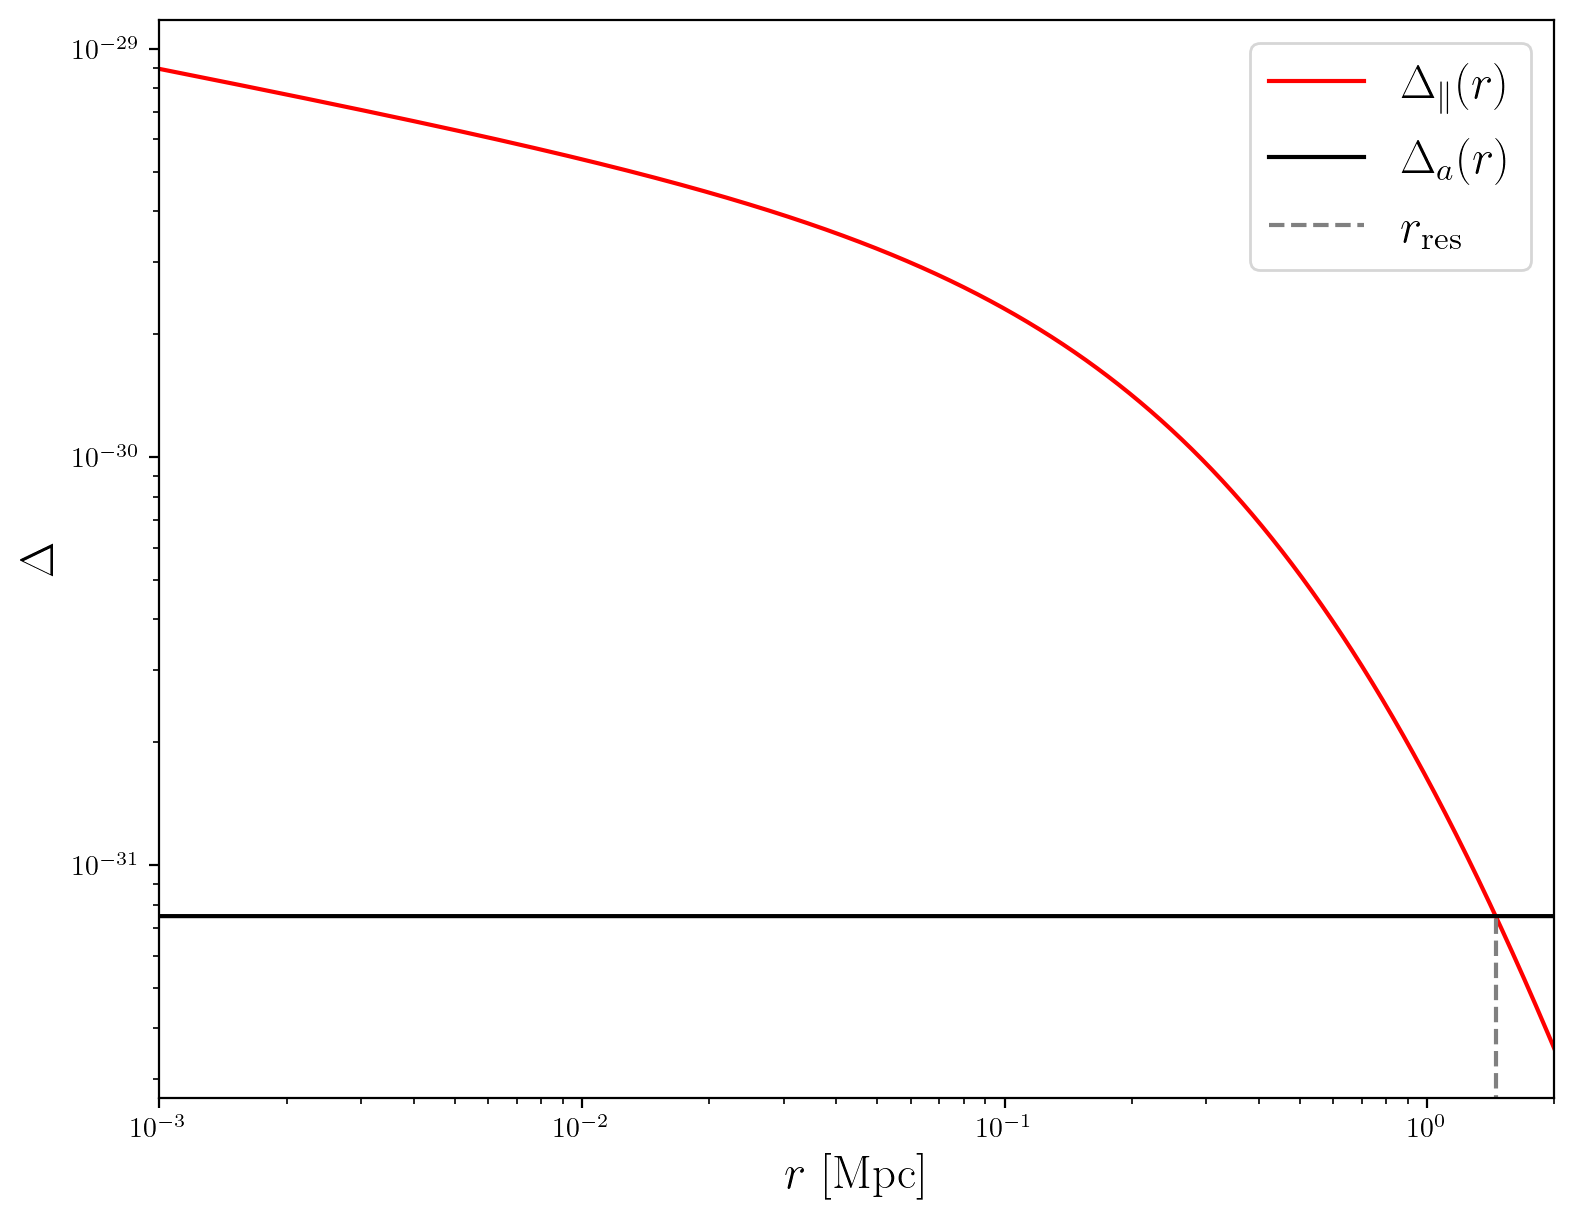

In [9]:
# Delta_parallel(r) vs Delta_a(r)


plt.plot(r_thr, Delta_parallelr(r_thr), color='r' , label = r'$\Delta_\parallel(r)$')
plt.plot(r_thr, Delta_ar(r_thr)*np.ones_like(r_thr), color='k',  label = r'$\Delta_a(r)$')
r_res_line = plt.vlines(r_res, 0, Delta_ar(r_res), linestyle='dashed', color='gray', label=r'$r_{\rm res}$')
plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-3, 2)
plt.xlabel(r"$r~[{\rm Mpc}]$", fontsize=17)
plt.ylabel(r"$\Delta$", fontsize=17)
plt.legend(fontsize=17)
plt.show()

In [10]:
########################################
# Mapping the halo model on the chord and setting the interval of integration
########################################

# Integration steps
z_num      = 5_000_001
z_num_half = (z_num + 1) // 2  # To ensure symmetry

# Define radial trajectory: from r_vir → r_min → r_vir (chord)
r_vals_1 = np.linspace(rvir, rmin, z_num_half)
r_vals_2 = np.linspace(rmin, rvir, z_num_half)
r_vals_on_trj = np.concatenate([r_vals_1, r_vals_2[1:]])  # Avoid duplicated rmin

# Projected distance along the chord
z_chord = np.sqrt(r_vals_on_trj**2 - rmin**2)

# Define the integration coordinate z_thr in Mpc (centered around 0)
z_thr = np.empty_like(z_chord) 
z_thr[:z_num_half]  = -z_chord[:z_num_half] + chord_length / 2 
z_thr[z_num_half:]  =  z_chord[z_num_half:] + chord_length / 2

# Optional: reference scale z_0 ≈ 1 Mpc (used in rescaling)
z_0 = z_thr[np.argmin(np.abs(z_thr - 1))]

# Associate n_e(r) along the trajectory, convert to eV³
ne_values_chord = n_er_interp(r_vals_on_trj)

# Prepare values for numba-interpolated function n_e(z)
z_vals = z_thr.copy()
ne_vals = ne_values_chord.copy()

@njit
def n_e(z, z_vals, ne_vals):
    return np.interp(z, z_vals, ne_vals)

In [11]:
########################################
# Specify functions of the model in the case of constant magnetic field and linear electron numerical density
########################################

def Delta_a(z):
    """
    Axion mass term 
    Delta_a = -m_a^2/(2*omega)
    """
    return m_a**2/(2*omega) 

Delta_a_value =  m_a**2/(2*omega) 
Delta_a_vals = np.array([Delta_a(z) for z in z_thr])


@njit
def m2_g(z, z_vals, ne_vals):
    """
    Effective mass of the photon
    acquired by scattering with free electrons
    """
    return ElementaryCharge**2 / mass_electron * n_e(z, z_vals, ne_vals)

m2_g_vals = np.array([m2_g(z, z_vals, ne_vals) for z in z_thr])


def B_T(z):
    """
    Transverse magnetic field
    """
    return  1 * 1e-6 * Gauss  #in \mu G 


@njit
def Delta_parallel(z, z_vals, ne_vals):
    """
    Photon mass term
    Delta_parallel = -m^2_\gamma(z)/2\omega
    """
    return m2_g(z, z_vals, ne_vals) / (2 * omega)

Delta_parallel_vals = np.array([Delta_parallel(z, z_vals, ne_vals) for z in z_thr])


if dark_photon:
    def Delta_ag(z):
        return eps*Delta_a(z)
else:
    def Delta_ag(z):
        """
        Axion-photon coupling term
        Delta_{a\gamma} = g_{a\gamma\gamma}/2 B_T(z)
        """
        return g_agg/2 * B_T(z)
    
Delta_ag_value = Delta_ag(0)
Delta_ag_vals =  np.array([Delta_ag(z) for z in z_thr])

@njit
def Delta_diff(z, z_vals, ne_vals, Delta_a_val):
    """
    Difference between Delta_parallel and Delta_a
    """
    return Delta_parallel(z, z_vals, ne_vals) - Delta_a_val

Delta_diff_vals = np.array([Delta_diff(z, z_vals, ne_vals, Delta_a_value) for z in z_thr])


In [12]:
########################################
# Specify functions of the model in the case of constant magnetic field and linear electron numerical density
########################################

#Searching where Delta_diff changes sign
sign_changes = np.where(np.diff(np.sign(Delta_diff_vals)) != 0)[0]

# Searchinf for all the roots of Delta_diff
z_resonances = []

for i in sign_changes:
    z_left = z_thr[i]
    z_right = z_thr[i + 1]
    
    try:
        sol = root_scalar(Delta_diff, bracket=[z_left, z_right], args=(z_vals, ne_vals, Delta_a_value), method='brentq')
        if sol.converged:
            z_resonances.append(sol.root)
    except ValueError:
        continue

z_resonances = np.array(z_resonances)

# Index of the resonance points
index_res1 = np.argmin(np.abs(z_thr - z_resonances[0]))
index_res2 = np.argmin(np.abs(z_thr - z_resonances[-1]))
index_crit = np.argmin(np.abs(z_thr - (z_resonances[0] + z_resonances[-1]) / 2))

# Corrispective values
z_res1 = z_resonances[0]
z_res2 = z_resonances[-1]
z_crit = (z_res1 + z_res2) / 2

In [13]:
z_res1

0.9755188251702277

In [14]:
z_res2

1.9386534415291863

In [15]:
########################################
# Computing the derivative of Delta_parallel and the factor gamma. 
########################################

dDelta_parallel = np.abs(np.gradient(Delta_parallel_vals, z_thr)) /(Mpc) #Recall here we are still working in Mpc units. 

gamma_factor = (Delta_ag_value)**2/(dDelta_parallel)
print('gamma at first res = ', gamma_factor[index_res1])
print('gamma at second res =' , gamma_factor[index_res2])
print('gamma at critical point =' , gamma_factor[index_crit])

gamma at first res =  0.003908758167738369
gamma at second res = 0.003908758167738369
gamma at critical point = inf


/var/folders/jc/kky54qz15j50ck9_kzrzk_d80000gn/T/ipykernel_88182/2693534018.py:7: RuntimeWarning: divide by zero encountered in divide
  gamma_factor = (Delta_ag_value)**2/(dDelta_parallel)


In [16]:
#Computing the probability à la C. Mondino, and comparing it with 2\pi\gamma

log = np.log(m2_g_vals)
derivative = np.abs(np.gradient(log, z_thr))**-1   

if dark_photon:
    prob_Mondino  = (np.pi * eps**2 * m_a**2/omega ) * derivative[index_res1] * Mpc #Here the resonance happens at z_shift, then you need the index of it
else:
    prob_Mondino  = omega * np.pi * g_agg**2 * B_T(z_thr[index_res1])**2 / m_a**2 * derivative[index_res1] * Mpc #Here the resonance happens at z_shift, then you need the index of it

print("2*pi*gamma is",  2*np.pi*gamma_factor[index_res1])
print("Mondino's probability is",  prob_Mondino)

2*pi*gamma is 0.024559451888851922
Mondino's probability is 0.0245594541954579


/var/folders/jc/kky54qz15j50ck9_kzrzk_d80000gn/T/ipykernel_88182/3108971535.py:4: RuntimeWarning: divide by zero encountered in reciprocal
  derivative = np.abs(np.gradient(log, z_thr))**-1


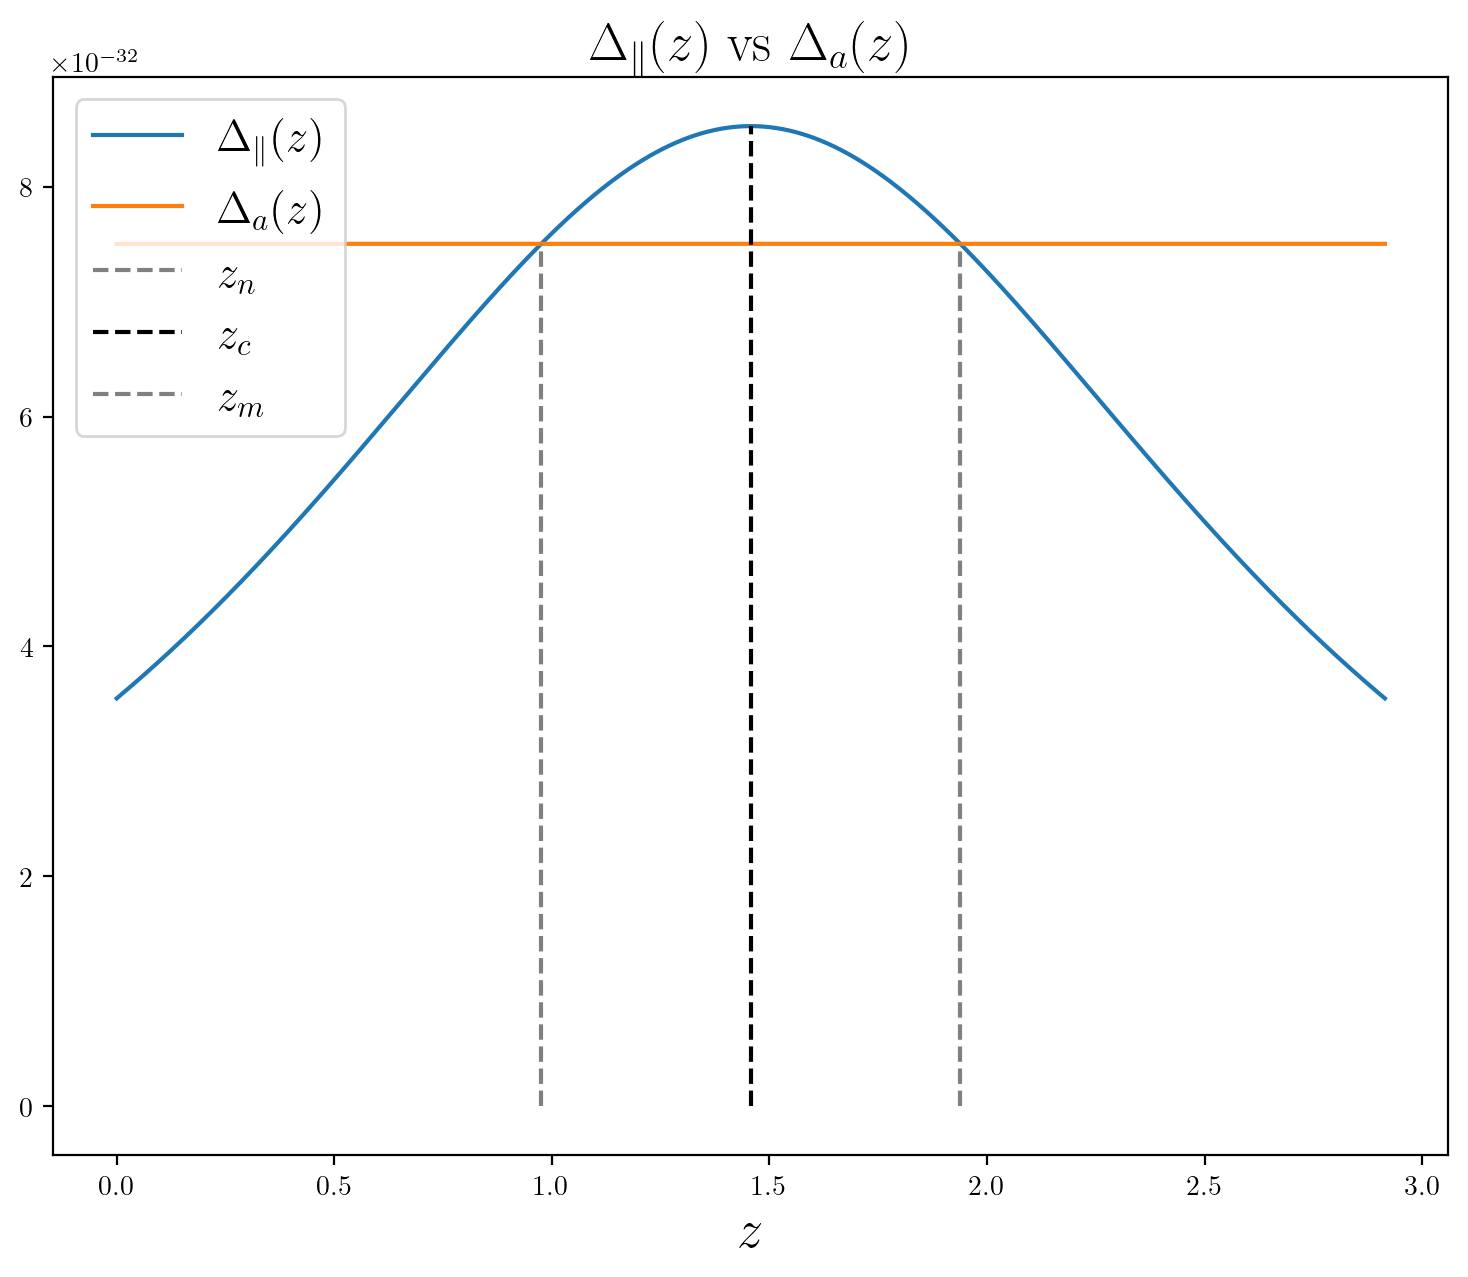

In [17]:
#Plotting Delta_parallel and Delta_a to check where resonance happens. 

plt.plot(z_thr, Delta_parallel_vals, label=r'$\Delta_\parallel(z)$')
plt.plot(z_thr, Delta_a_vals, label=r'$\Delta_a(z)$')

z_n_line = plt.vlines(z_res1, 0, Delta_a_value, linestyle='dashed', color='gray', label=r'$z_n$')
z_c_line = plt.vlines(z_crit, 0, Delta_parallel_vals[index_crit], linestyle='dashed', color='black', label=r'$z_c$')
z_m_line = plt.vlines(z_res2, 0, Delta_a_value, linestyle='dashed', color='gray', label=r'$z_m$')

plt.title(r'$\Delta_\parallel(z)$ vs $\Delta_a(z)$', fontsize=19)
plt.xlabel(r'$z$', fontsize=19)

plt.legend(fontsize=16, loc='upper left')

plt.show()

148.756865650208
295.62526329878557


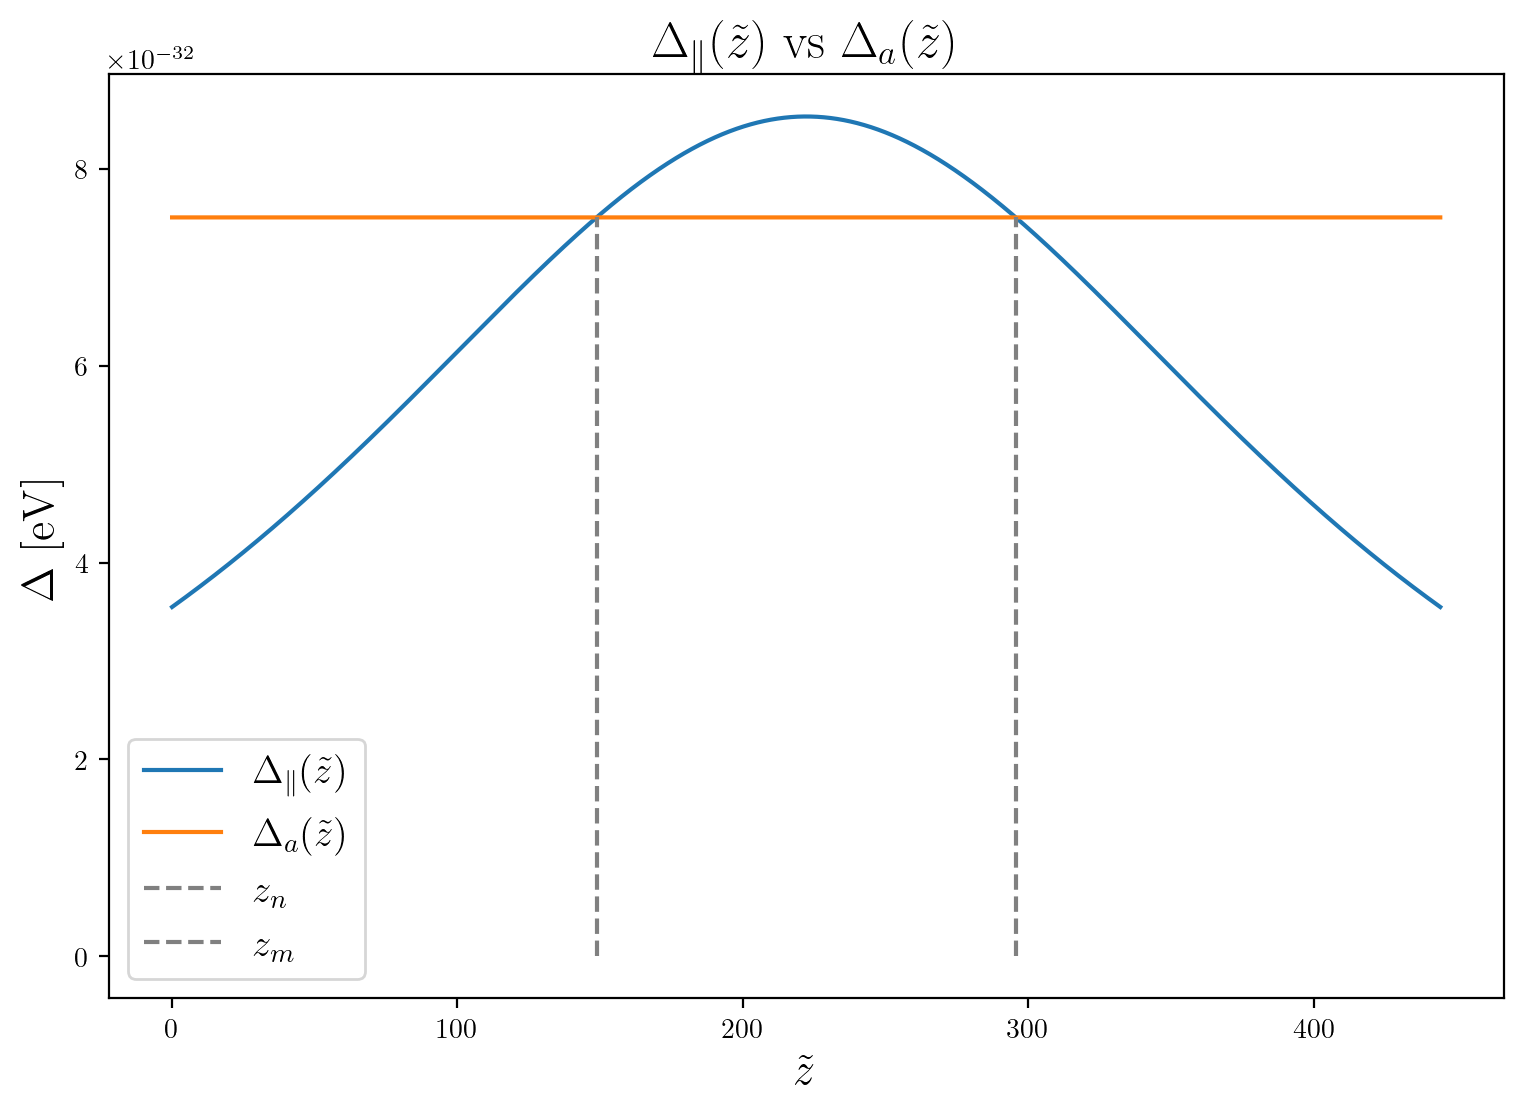

In [18]:
########################################
# Conversion from z_thr in Mpc to tilde{z}, because both the Battaglia profile and the mapping were computed in units of Mpc
########################################

#Defining \tilde{z}
z_tilde_thr = Delta_ag_vals * Mpc * z_thr

#Computing Delta_parallel_tilde and its values
@njit
def Delta_parallel_tilde(zt, Delta_ag_val, z_vals, ne_vals):
    z_phys = zt / (Delta_ag_val * Mpc)
    return Delta_parallel(z_phys, z_vals, ne_vals)

Delta_parallel_tilde_vals = np.array([Delta_parallel_tilde(z, Delta_ag_value, z_vals, ne_vals) for z in z_tilde_thr])

#Computing z_tilde_res
z_tilde_res1 = Delta_ag_value * Mpc * z_res1
z_tilde_res2 = Delta_ag_value * Mpc * z_res2
print(z_tilde_res1)
print(z_tilde_res2)


# Plotting Delta_parallel(z_tilde) and Delta_a(z_tilde)
plt.figure(figsize=(9, 6))
plt.plot(z_tilde_thr, Delta_parallel_tilde_vals, label=r"$\Delta_\parallel(\tilde{z})$")
plt.plot(z_tilde_thr, Delta_a_vals, label=r"$\Delta_a(\tilde{z})$")
z_tilde_n_line = plt.vlines(z_tilde_res1, 0, Delta_a_value, linestyle='dashed', color='gray', label=r'$z_n$')
z_tilde_m_line = plt.vlines(z_tilde_res2, 0, Delta_a_value, linestyle='dashed', color='gray', label=r'$z_m$')

plt.xlabel(r"$\tilde{z}$", fontsize=16)
plt.ylabel(r"$\Delta~[\mathrm{eV}]$", fontsize=16)
plt.title(r"$\Delta_\parallel(\tilde{z})$ vs $\Delta_a(\tilde{z})$", fontsize=18)
plt.legend(fontsize=14)
plt.show()

In [19]:
#Computing the derivative of Delta_parallel and the factor gamma in units of Delta_ag Mpc

dDelta_parallel_tilde = np.abs(np.gradient(Delta_parallel_tilde_vals, z_tilde_thr ))

gamma_factor_tilde = (Delta_ag_value)/(dDelta_parallel_tilde)
print('gamma at first res = ', gamma_factor_tilde[index_res1])
print('gamma at second res =' , gamma_factor_tilde[index_res2])
print('gamma at critical point =' , gamma_factor_tilde[index_crit])

gamma at first res =  0.0039087581684201225
gamma at second res = 0.003908758167717449
gamma at critical point = inf


/var/folders/jc/kky54qz15j50ck9_kzrzk_d80000gn/T/ipykernel_88182/128796486.py:5: RuntimeWarning: divide by zero encountered in divide
  gamma_factor_tilde = (Delta_ag_value)/(dDelta_parallel_tilde)


In [20]:
################################################################
# Defining the solver for the photon-to-axion equation for |a>
################################################################

@njit
def master_eq_LZ_1_numba(z, S, z_tilde_vals, Delta_parallel_tilde_vals, Delta_a_val, Delta_ag_val):
    ax, f = S[0], S[1]

    # Interpolation of Delta_parallel_tilde
    Delta_parallel_tilde_interp = np.interp(z, z_tilde_vals, Delta_parallel_tilde_vals)
    
    # Defining the ODE
    dSdz_0 = f
    dSdz_1 = -1j * (Delta_parallel_tilde_interp - Delta_a_val) / Delta_ag_val * f - ax

    return np.array([dSdz_0, dSdz_1], dtype=np.complex128)

#Initial values for the ODE
z_init = z_tilde_thr[0]
ic_LZ = np.array([ 0, -1j ], dtype=np.complex128)


In [21]:
########################################
# Cutting the total interval to reduce the computing time of the solver
########################################

cut = True

# The bounds of the interval are defined with the \lambda_resonance = \sqrt{2\pi\gamma} and a constant c
R_length_tilde =  np.sqrt(2*np.pi*gamma_factor)
c = 30
Delta_z_first = c * R_length_tilde[index_res1]
Delta_z_second = c * R_length_tilde[index_res2]


if cut: 
    z_min = z_tilde_res1 - Delta_z_first
    z_max = z_tilde_res2 + Delta_z_second
    z_tilde_thr_cut = np.linspace(z_min, z_max, 1_000_000)

    # In the case you want to force to include the resonance points
    #idx1 = np.argmin(np.abs(z_tilde_thr_cut - z_tilde_res1))
    #z_tilde_thr_cut[idx1] = z_tilde_res1

    #idx2 = np.argmin(np.abs(z_tilde_thr_cut - z_tilde_res2))
    #z_tilde_thr_cut[idx2] = z_tilde_res2

else:
    z_tilde_thr_cut = z_tilde_thr
    
    
#Interpolating Delta_parallel_tilde over z_tilde_thr_cut (wheter or not there is a cut)
Delta_parallel_tilde_cut_interp = np.interp(z_tilde_thr_cut, z_tilde_thr, Delta_parallel_tilde_vals)

In [22]:
# Check if the resonance points are present
contains_z1 = np.any(z_tilde_thr_cut == z_tilde_res1)
contains_z2 = np.any(z_tilde_thr_cut == z_tilde_res2)

# If not, check how close the points are
diff1 = np.min(np.abs(z_tilde_thr_cut - z_tilde_res1))
diff2 = np.min(np.abs(z_tilde_thr_cut - z_tilde_res2))

print(f"z_tilde_res1 = {z_tilde_res1}")
print(f"z_tilde_res2 = {z_tilde_res2}")
print(f"z_tilde_thr_cut contains z_tilde_res1? {contains_z1}")
print(f"z_tilde_thr_cut contains z_tilde_res2? {contains_z2}")
print(f"Min |z - z_tilde_res1| in grid = {diff1:.3e}")
print(f"Min |z - z_tilde_res2| in grid = {diff2:.3e}")

z_tilde_res1 = 148.756865650208
z_tilde_res2 = 295.62526329878557
z_tilde_thr_cut contains z_tilde_res1? False
z_tilde_thr_cut contains z_tilde_res2? False
Min |z - z_tilde_res1| in grid = 1.077e-05
Min |z - z_tilde_res2| in grid = 1.077e-05


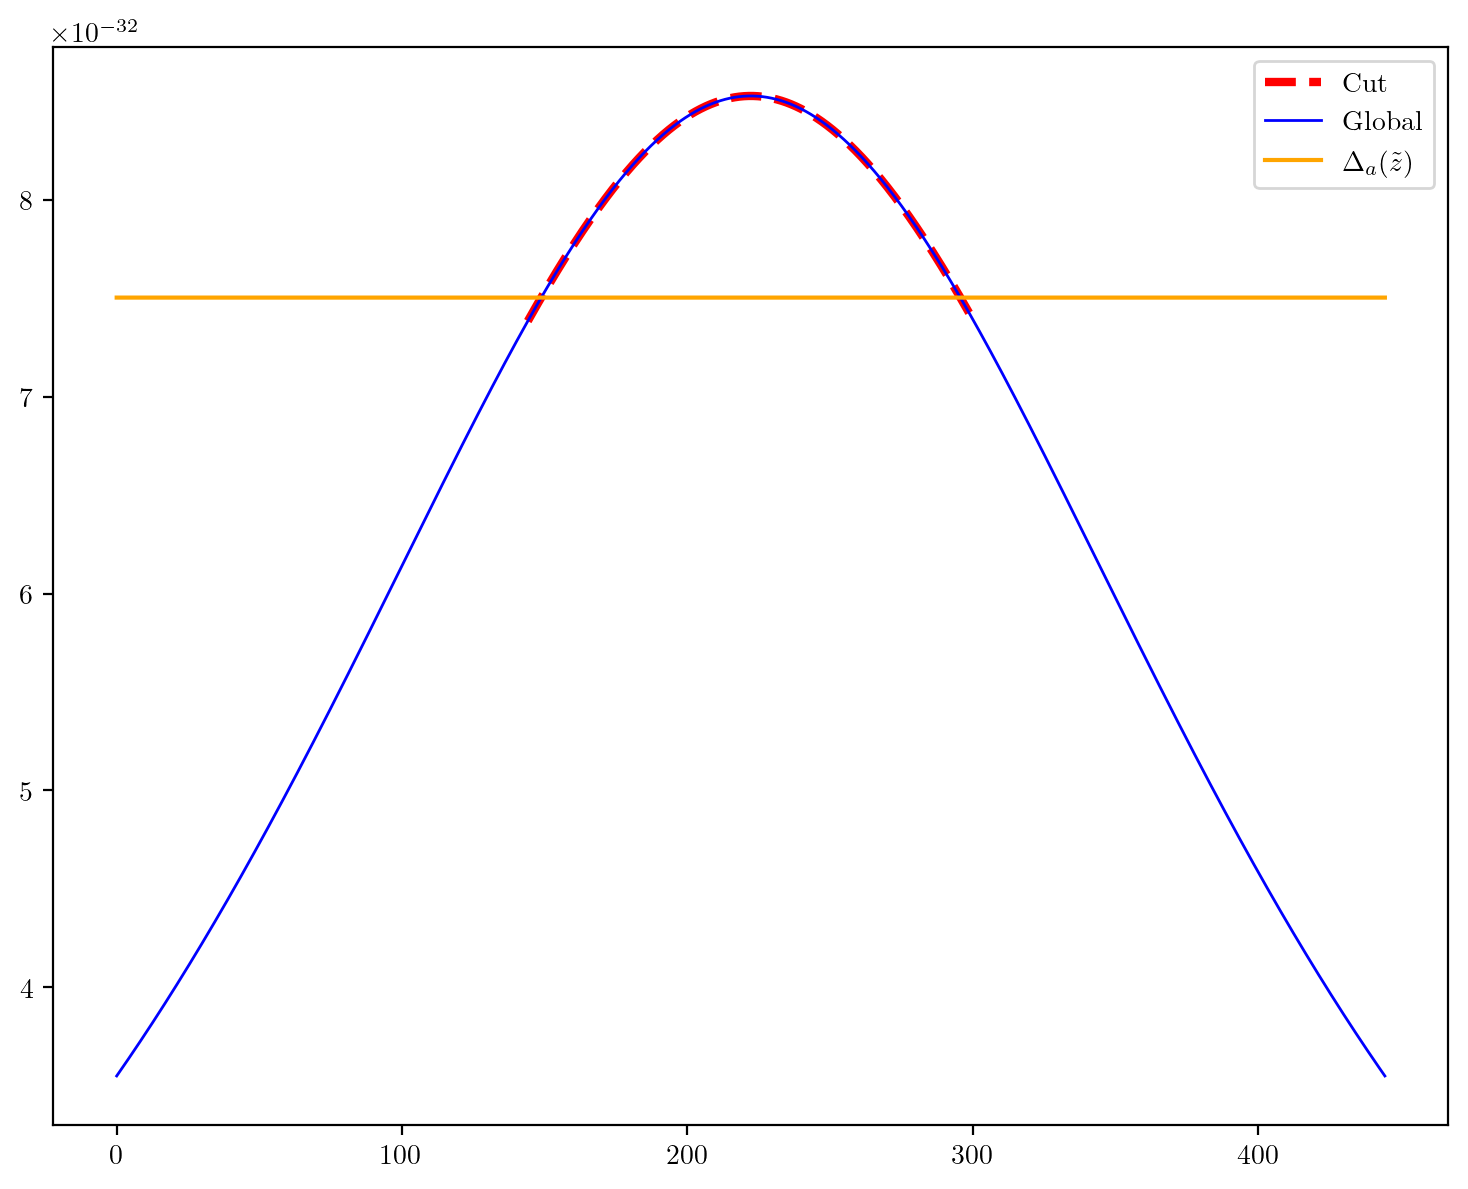

In [23]:
plt.plot(z_tilde_thr_cut, Delta_parallel_tilde_cut_interp, ls='--', color='red', linewidth=3, label='Cut')
plt.plot(z_tilde_thr, Delta_parallel_tilde_vals, color='blue', linewidth=1, label='Global')
plt.plot(z_tilde_thr, Delta_a_vals, label=r"$\Delta_a(\tilde{z})$", color='orange')
plt.legend()
plt.show()

In [24]:
########################################
# Solving the equation on z_tilde_thr_cut 
########################################

# Wrapper to be compatible with solve_ivp
def wrapper_master_eq(z, S):
    return master_eq_LZ_1_numba(
        z,
        S,
        z_tilde_thr_cut,
        Delta_parallel_tilde_cut_interp,
        Delta_a_value,
        Delta_ag_value
    )


computed = False

if computed:
    print("Loading full solution from solution_LZ_full.npz")

    data = np.load("solution_LZ_full.npz")

    # Extract components
    z_tilde_thr_cut = data["z"]
    p_LZ_1_increasing_decreasing = data["prob"]
    y0 = data["a"]
    y1 = data["da"]

    # Reconstruct object to keep the same interface
    class DummySol:
        pass

    sol_LZ_1_increasing_decreasing = DummySol()
    sol_LZ_1_increasing_decreasing.y = np.vstack([y0, y1])
    sol_LZ_1_increasing_decreasing.t = z_tilde_thr_cut
    
else:
    print("Solve the ODE using the fast Numba-compatible wrapper and saving it")
    sol_LZ_1_increasing_decreasing = solve_ivp(
        wrapper_master_eq,
        (z_tilde_thr_cut[0], z_tilde_thr_cut[-1]),
        ic_LZ,
        method='DOP853',
        t_eval=z_tilde_thr_cut,
        rtol=1e-8,
        atol=1e-10
    )

    # Compute the probability from the axion amplitude
    p_LZ_1_increasing_decreasing = np.abs(sol_LZ_1_increasing_decreasing.y[0])**2

    # Save everything in a single .npz file
    np.savez(
    "solution_LZ_full.npz",
    z=z_tilde_thr_cut,                                   # grid
    a=sol_LZ_1_increasing_decreasing.y[0],              # a(z)
    da=sol_LZ_1_increasing_decreasing.y[1],             # da/dz
    prob=np.abs(sol_LZ_1_increasing_decreasing.y[0])**2 # probability
    )


Solve the ODE using the fast Numba-compatible wrapper and saving it


In [25]:
########################################
# #Averaging the probability from the second resonance point on, in order to obtain the mean mean value: 
########################################

index_res1_cut = np.argmin(np.abs(z_tilde_thr_cut - z_tilde_thr[index_res1]))
index_res2_cut = np.argmin(np.abs(z_tilde_thr_cut - z_tilde_thr[index_res2]))

P_mean_value_2nd_res = np.average(p_LZ_1_increasing_decreasing[index_res2_cut: ])
print(P_mean_value_2nd_res)
print(P_mean_value_2nd_res/(8*np.pi*gamma_factor[index_res1]))

0.00011018182551461845
0.0011215827007588107


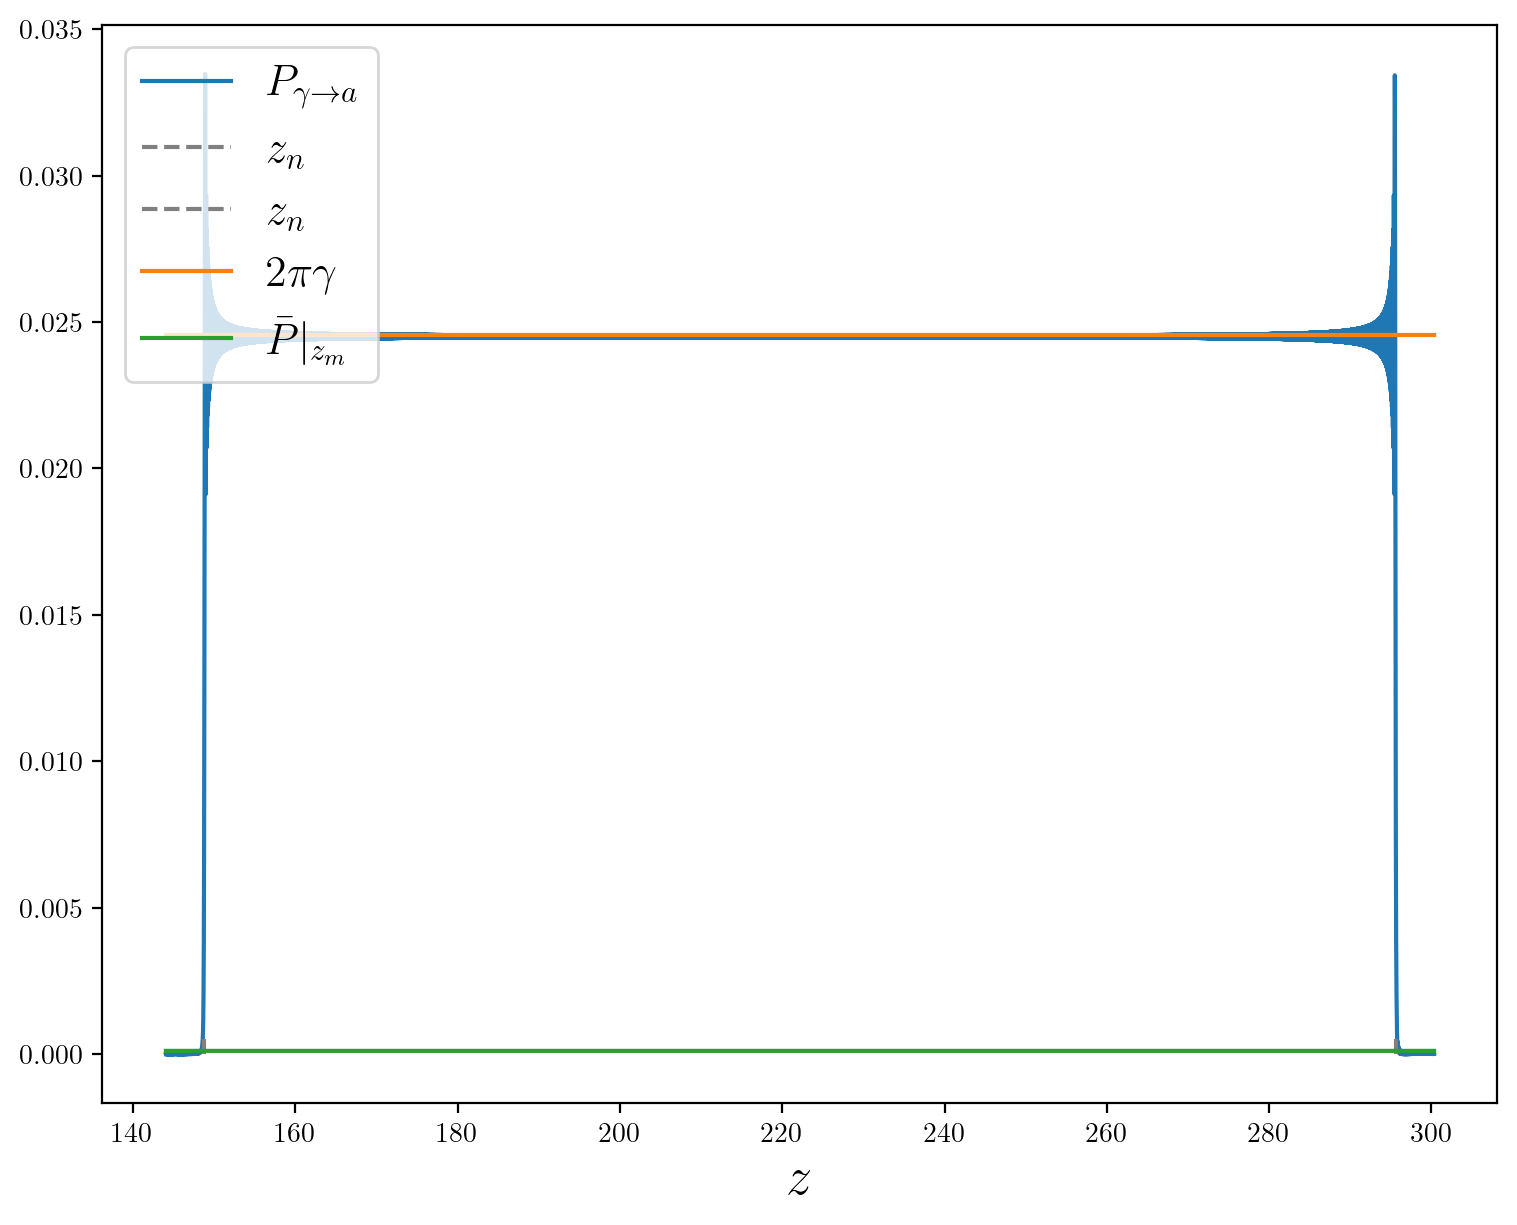

In [26]:
########################################
# Plotting the solution 
########################################

plt.plot(z_tilde_thr_cut, p_LZ_1_increasing_decreasing, label=r'$P_{\gamma \rightarrow a}$')
z_n_line = plt.vlines(z_tilde_thr_cut[index_res1_cut], 0,0.0005, linestyle='dashed', color='gray', label=r'$z_n$')
z_n_line = plt.vlines(z_tilde_thr_cut[index_res2_cut], 0,0.0005, linestyle='dashed', color='gray', label=r'$z_n$')
plt.plot(z_tilde_thr_cut, 2*np.pi*gamma_factor_tilde[index_res1]*np.ones_like((z_tilde_thr_cut)), label=r'$2\pi\gamma$')
plt.plot(z_tilde_thr_cut,P_mean_value_2nd_res*np.ones_like(z_tilde_thr_cut), label=r'$\bar{P}|_{z_m}$')
#plt.plot(z_tilde_thr_cut, 8*np.pi*gamma_factor_tilde[index_res1]*np.ones_like((z_tilde_thr_cut)), label=r'$8\pi\gamma$')
plt.xlabel(r'$z$', fontsize=19)
plt.legend(fontsize=16, loc='upper left')

# Comparison with respect to the analytical formula.

For multiple resonance cases there are Quantum Mechanics effect of interference between the waves. In the paper by Brahma et al. (https://arxiv.org/abs/2308.08586) these phase effects are studied. 
The proposed equation for multiple level crossing is

$ P_{\gamma \mapsto a} = \sum_n (2\pi \gamma_n) + 2 \sum_{n<m} \sqrt{(2\pi\gamma_n) (2\pi \gamma_m) } \cos{\Phi_{nm}} $, 

where $\Phi_{nm}$ is a certain phase: 

$\Phi_{nm} = \Phi(z_n) - \Phi(z_m) +\frac{\pi}{4} (\sigma_n-\sigma_m)$

where $\Phi(z)$ is defined to be

$\Phi(z) = \int_{z_i}^{z} (\Delta_\parallel(z) - \Delta_a) dz = \int_{\tilde{z}_i}^{\tilde{z}} d\tilde{z}'_A \, \frac{\Delta_\parallel(\tilde{z}') - \Delta_a}{\Delta_{a\gamma}}$

and

$\sigma(z) = \text{sign}\left[\Phi''(z)\right] = \text{sign}\left[\Delta'_\parallel(z)\right]$.

For two resonance points and in our case of linear increasing-decreasing we have

$\Phi_{nm} = \int_{z_m}^{z_n} \ (\Delta_\parallel(z) -\Delta_a) dz -\frac{\pi}{2} = \frac{1}{2} 2\bar{z} \frac{\Delta_a}{z_0} \bar{z} -\frac{\pi}{2}$.

From the probability equation, being $\cos{\Phi_{nm}}$ maximum in 1, minumum in -1 and on average 0 we get that, in our case of two resonance points ($n=1,2$) where $\gamma_n = \gamma_m$: 

1) Maximum at: $2\pi\gamma (1+1+2) = 4 (2\pi\gamma)$

2) Mean at: $2\pi\gamma (1+1+0) = 2 (2\pi\gamma)$

3) Minum at: $2\pi\gamma (1+1-2) = 0$


In [27]:

def Delta_parallel_minus_Delta_a_tilde(zt):
    Delta_parallel_val = np.interp(zt, z_tilde_thr, Delta_parallel_tilde_vals)
    return Delta_parallel_val - Delta_a_value

integral, error = quad(Delta_parallel_minus_Delta_a_tilde, z_tilde_res2, z_tilde_res1) # Integrating Delta_\parallel - Delta_a from z_res1 to z_res2
area = (-1) / Delta_ag_value * integral #Renormalized integral by 1/(Delta_ag(z_res1)), as we did for the ODE solver.

phi_nm = area - np.pi / 2 #Computing the phase
factor = 1 + 1 + 2 * np.cos(phi_nm)  # P = 2πγ × factor

print(f"Area = {area}, estimated error: {error}")
print(f"Phi_nm = {phi_nm}")
print(f"Probability factor = {factor}")
print(f"Area / (2π) = {area / (2 * np.pi)}")


#From the probability at the second resonance point we can compute the numerical \Phi_nm and the numerical factor 

numerical_phase = np.arccos( (P_mean_value_2nd_res - 4*np.pi*gamma_factor[index_res2])/(4*np.pi*gamma_factor[index_res2]) )
numerical_factor = 1+1+2*np.cos(numerical_phase)
print('Numerical prob factor = ', numerical_factor)


#Error num vs ana

error_2nd_prob = np.abs((numerical_factor-factor)/factor)
print('Error num vs ana = ', error_2nd_prob)


Area = 1005766.6541708268, estimated error: 1.6217200165330919e-44
Phi_nm = 1005765.0833744999
Probability factor = 0.009345344500389707
Area / (2π) = 160072.7346082839
Numerical prob factor =  0.004486330803035177
Error num vs ana =  0.5199394947026197


# Wave length at the resonances and far from them

[1.01564142e-06 1.01564170e-06 1.01564198e-06 ... 1.01564198e-06
 1.01564170e-06 1.01564142e-06]
[0.00513307 0.00513325 0.00513342 ... 0.00513342 0.00513325 0.00513307]


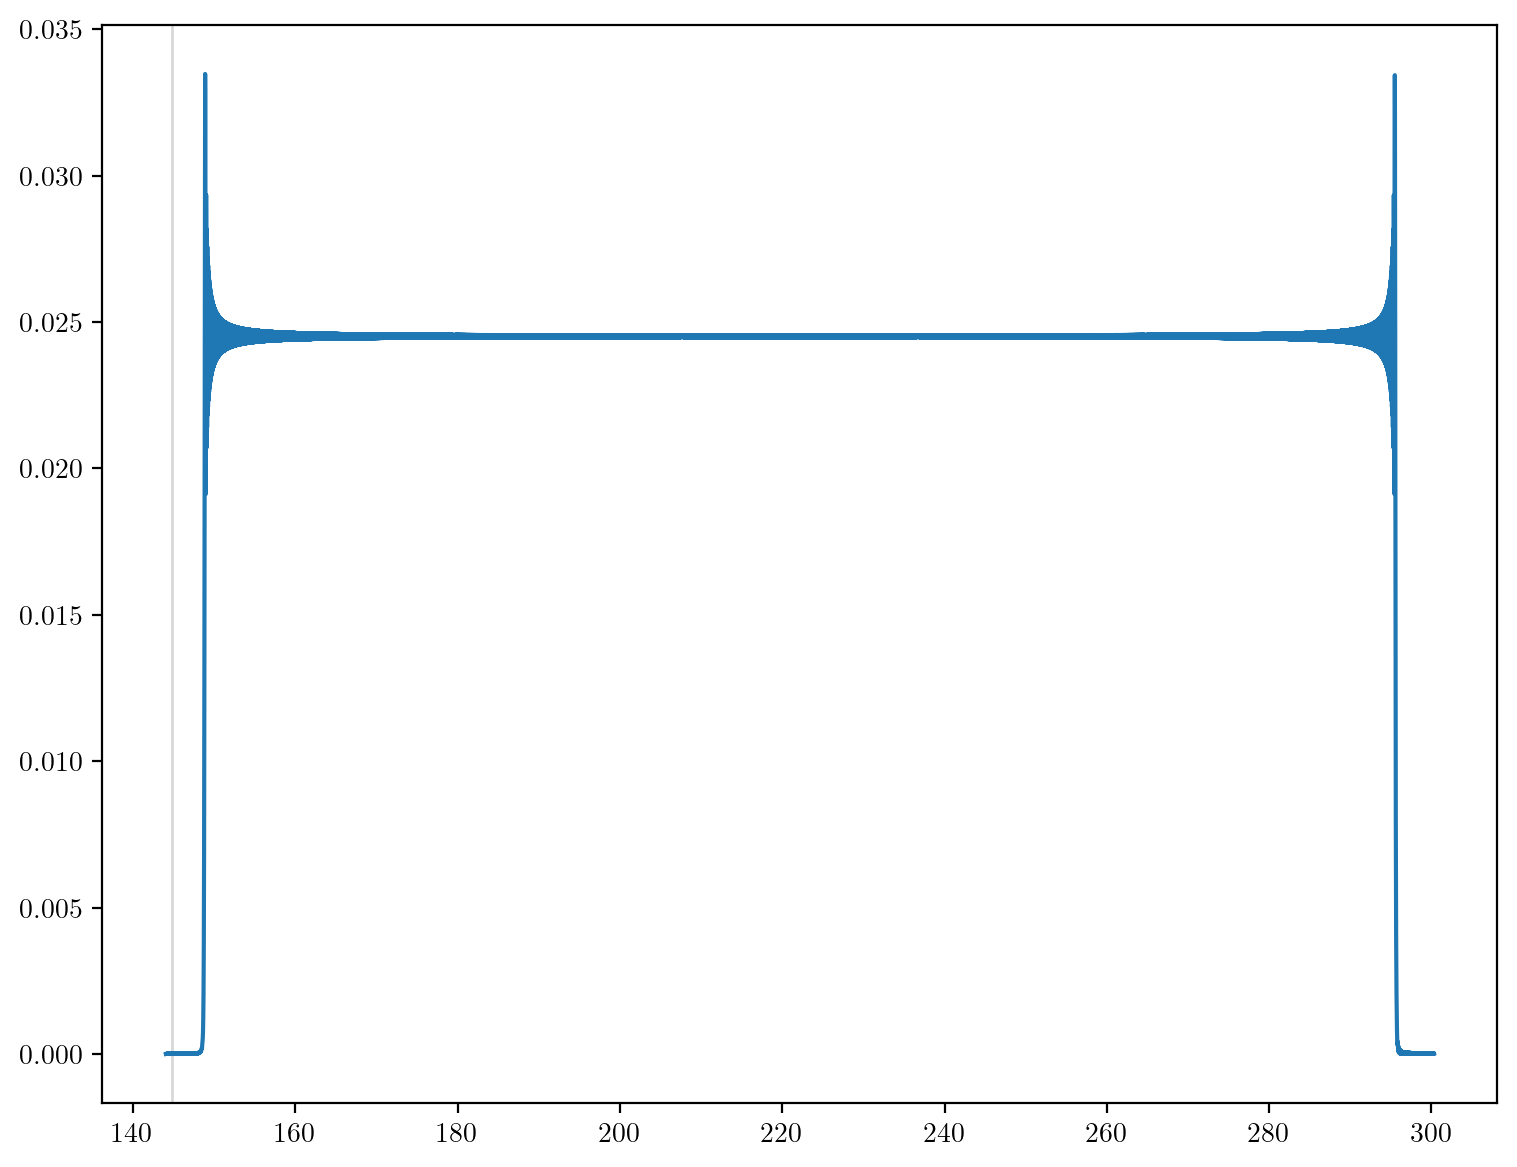

In [28]:
########################################
# On the oscillation length
########################################

l_osc = np.abs(2 * np.pi / (Delta_parallel_vals - Delta_a_value)) / Mpc
print(l_osc)
losc_tilde = np.abs(2 * np.pi / ((Delta_parallel_tilde_cut_interp - Delta_a_value) / Delta_ag_value))
print(losc_tilde)


plt.plot(z_tilde_thr_cut, p_LZ_1_increasing_decreasing, label=r'$P_{\gamma \rightarrow a}$')
plt.axvspan( z_tilde_thr_cut[5000],z_tilde_thr_cut[5000] + losc_tilde[5000], color='gray', alpha=0.3) 
#plt.xlim(169.97,169.975)
#plt.ylim(0.013,0.014)

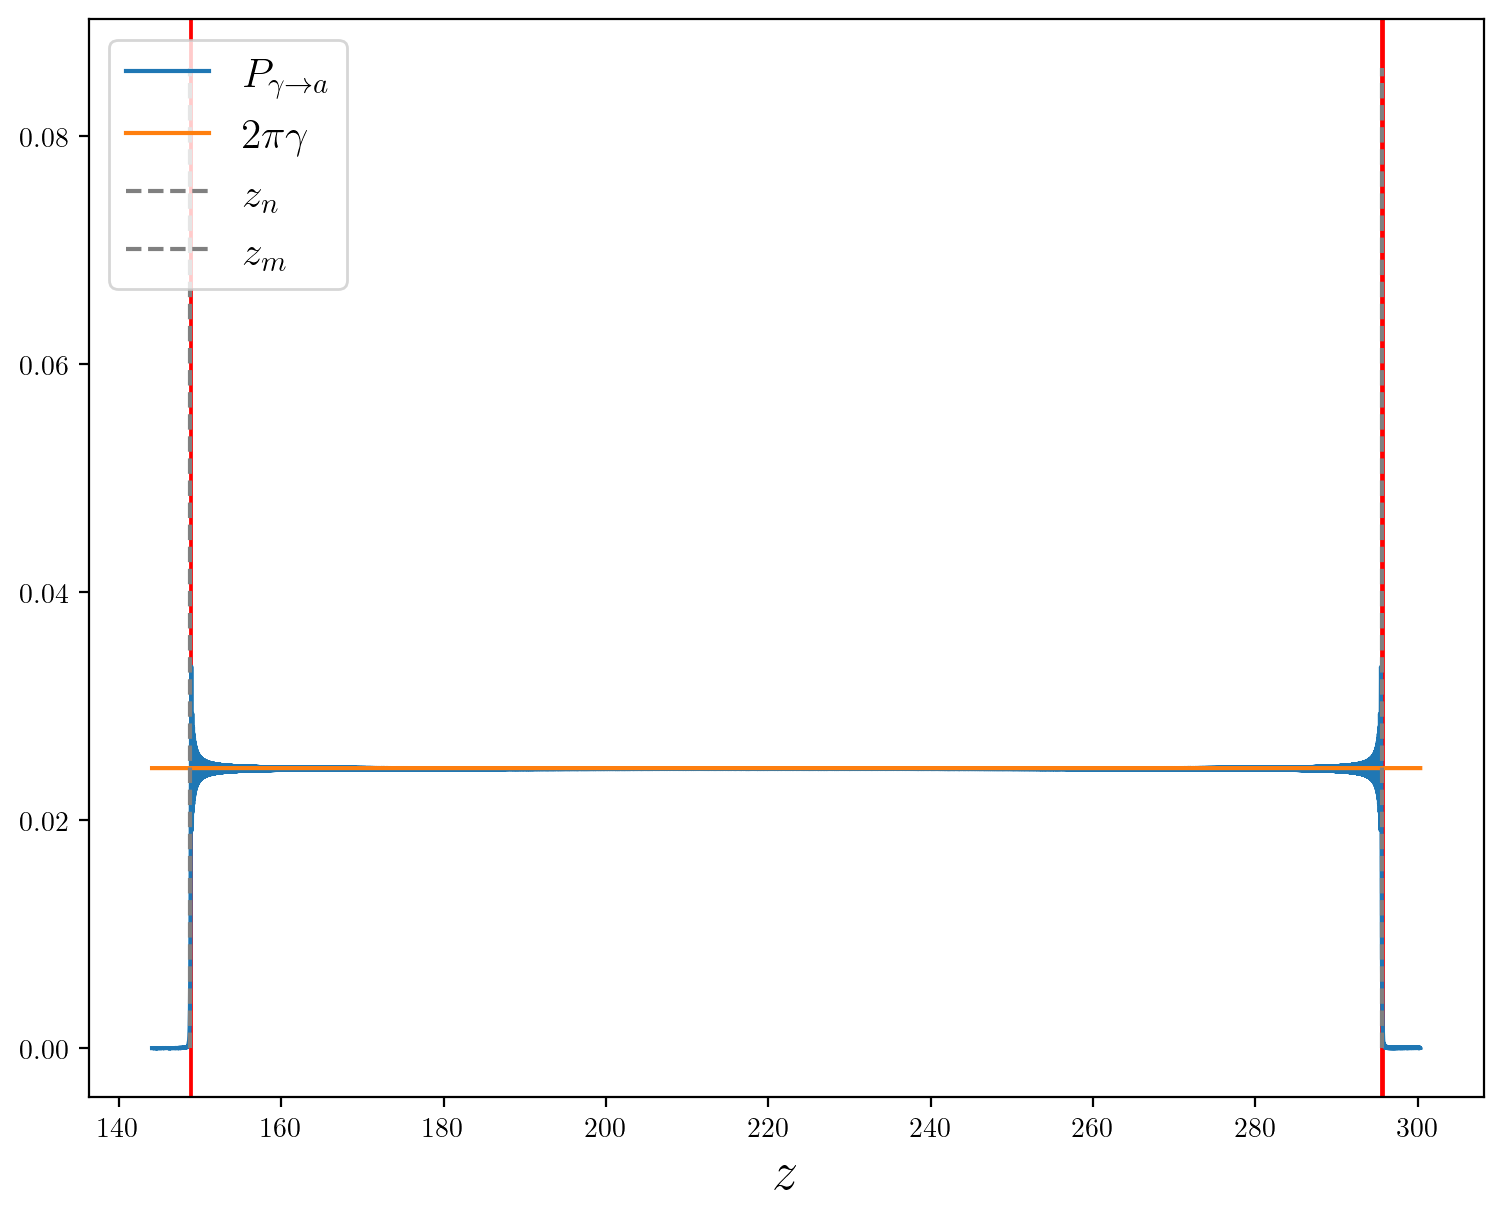

In [29]:
########################################
# On the resonance length
########################################

#The resonange length is defined above

#Plotting the solution
plt.plot(z_tilde_thr_cut, p_LZ_1_increasing_decreasing, label=r'$P_{\gamma \rightarrow a}$')
plt.axvspan( (z_tilde_thr_cut[index_res1_cut] - R_length_tilde[index_res1]/2).item(), (z_tilde_thr_cut[index_res1_cut] + R_length_tilde[index_res1]/2).item(), color='red', alpha=1) 
plt.axvspan( (z_tilde_thr_cut[index_res2_cut] - R_length_tilde[index_res2]/2).item(), (z_tilde_thr_cut[index_res2_cut] + R_length_tilde[index_res2]/2).item(), color='red', alpha=1) 
plt.plot(z_tilde_thr_cut, 2*np.pi*gamma_factor[index_res1]*np.ones_like(z_tilde_thr_cut), label=r'$2\pi\gamma$')

z_n_line = plt.vlines(z_tilde_thr_cut[index_res1_cut], 0,7*np.pi*gamma_factor[index_res1], linestyle='dashed', color='gray', label=r'$z_n$')
z_m_line = plt.vlines(z_tilde_thr_cut[index_res2_cut], 0, 7*np.pi*gamma_factor[index_res1], linestyle='dashed', color='gray', label=r'$z_m$')

plt.xlabel(r'$z$', fontsize=19)
plt.legend(fontsize=15, loc='upper left') 

# Integration on two small subintervals around the two points of resonance

Instead of integrating on the whole interval, or on an interval which includes both the resonance points, to accelerate the process we want to define two different intervals around the points of resonance. In order to do so, we want need to fix the initial conditions on the initial point of the second interval. To do so, we start from the last point of the first interval and we define the first point of the second interval after $N$ oscillations. In order to do that, and because the wavelength $l_{osc}(z)$ depends on $z$, we need to compute the a cumulative phase starting from $z_1$ and from it search for the point $z_2$ in order that the cumulative phase between the two points is $2\pi N$, with $N$ pretty big. 

In [30]:
########################################
# Defining the first interval around the first point of resonance
########################################


z_min1 = z_tilde_res1 - Delta_z_first
z_max1 = z_tilde_res1 + Delta_z_first
N1 = 1_000_000  
z_tilde_thr_cut1 = np.linspace(z_min1, z_max1, N1)

# Forcing z_tilde_res1 to be in the interval
#idx1 = np.argmin(np.abs(z_tilde_thr_cut1 - z_tilde_res1))
#z_tilde_thr_cut1[idx1] = z_tilde_res1

#Interpolating Delta_parallel_tilde on this interval    
Delta_parallel_tilde_cut_interp1 = np.interp(z_tilde_thr_cut1, z_tilde_thr, Delta_parallel_tilde_vals)


In [31]:
########################################
# Defining the interval z_grid to search for z_2_min and interpolating the quantities over it.
########################################

z_grid = np.linspace(z_tilde_thr_cut1[-1], z_tilde_res2  - Delta_z_second, 5_000_000)  

Delta_parallel_tilde_grid = np.interp(z_grid, z_tilde_thr, Delta_parallel_tilde_vals)

Delta_parallel_minus_Delta_a_grid = Delta_parallel_tilde_grid - Delta_a_value

Delta_ag_grid = np.interp(z_grid, z_tilde_thr, Delta_ag_vals)

In [32]:
########################################
# Computing the phase cumulative integral and the total phase over z_grid
########################################

# Cumulatinve integral of the phase over z_grid
phase_integrand = Delta_parallel_minus_Delta_a_grid / Delta_ag_grid
phi_cumulative = cumulative_trapezoid(phase_integrand, z_grid, initial=0)
phi_total = phi_cumulative[-1] #total phase over the entire interval

# Estimate the number of full oscillations N ≈ Phi_total / 2pi
N_estimate =int(np.floor(phi_total / (2 * np.pi))) 
print(f" N ≈ {N_estimate}")

 N ≈ 159184


In [33]:
########################################
# Interpolating Phi(z) and searching for z_2 such that Phi = 2πN
########################################

# Inverse interpolation to find z(Φ)
interp_z_of_phi = interp1d(phi_cumulative, z_grid, kind='cubic', bounds_error=True)

# Target cumulative phase: Φ = 2πN
N = N_estimate
phi_target = 2 * np.pi * N

# Corresponding z where Φ(z) = 2πN
z_tilde_thr_cut2_min = interp_z_of_phi(phi_target)

print(f"z_2 found: {z_tilde_thr_cut2_min}")

z_2 found: 290.9234639476302


In [34]:
# To make a good inversion interp, we need phi_comumulative monothonic
assert np.all(np.diff(phi_cumulative) > 0), "Phi is not monothonic, change the last point of z_grid"

In [35]:
########################################
# Defining the second interval around the second point of resonance
########################################

z_min2 = z_tilde_thr_cut2_min
z_max2 = z_tilde_res2 + Delta_z_second
N2 = 1_000_000  # High resolution (N2>>N1) to accurately resolve the second resonance
z_tilde_thr_cut2 = np.linspace(z_min2, z_max2, N2)

# # Forcing z_tilde_res1 to be in the interval
#idx2 = np.argmin(np.abs(z_tilde_thr_cut2 - z_tilde_res2))
#z_tilde_thr_cut2[idx2] = z_tilde_res2

#Interpolating Delta_parallel_tilde on this interval:
Delta_parallel_tilde_cut_interp2 = np.interp(z_tilde_thr_cut2, z_tilde_thr, Delta_parallel_tilde_vals)

In [36]:
#########################################################################
# Solving the equation separately on the first and the second intervals
#########################################################################

# First interval:

ic_LZ1 = np.array([ 0, -1j ], dtype=np.complex128)

def wrapper_master_eq1(z, S):
    return master_eq_LZ_1_numba(
        z, S,
        z_tilde_thr_cut1,
        Delta_parallel_tilde_cut_interp1,
        Delta_a_value,
        Delta_ag_value
    )

sol_LZ_1_increasing_decreasing1 = solve_ivp(wrapper_master_eq1,(z_tilde_thr_cut1[0], z_tilde_thr_cut1[-1]),ic_LZ1,method='DOP853',t_eval=z_tilde_thr_cut1,rtol=1e-8,atol=1e-10)

p_LZ_1_increasing_decreasing1 = np.abs(sol_LZ_1_increasing_decreasing1.y[0])**2

# Second interval:

ic_LZ2 = np.array([ sol_LZ_1_increasing_decreasing1.y[0][-1], sol_LZ_1_increasing_decreasing1.y[1][-1]  ], dtype=np.complex128)

def wrapper_master_eq2(z, S):
    return master_eq_LZ_1_numba(
        z, S,
        z_tilde_thr_cut2,
        Delta_parallel_tilde_cut_interp2,
        Delta_a_value,
        Delta_ag_value
    )

ic_LZ2 = np.array([ sol_LZ_1_increasing_decreasing1.y[0][-1], sol_LZ_1_increasing_decreasing1.y[1][-1]  ], dtype=np.complex128)

sol_LZ_1_increasing_decreasing2 = solve_ivp(wrapper_master_eq2,(z_tilde_thr_cut2[0], z_tilde_thr_cut2[-1]),ic_LZ2,method='DOP853',t_eval=z_tilde_thr_cut2,rtol=1e-8,atol=1e-10)

p_LZ_1_increasing_decreasing2 = np.abs(sol_LZ_1_increasing_decreasing2.y[0])**2



/opt/miniconda3/envs/cosmo_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


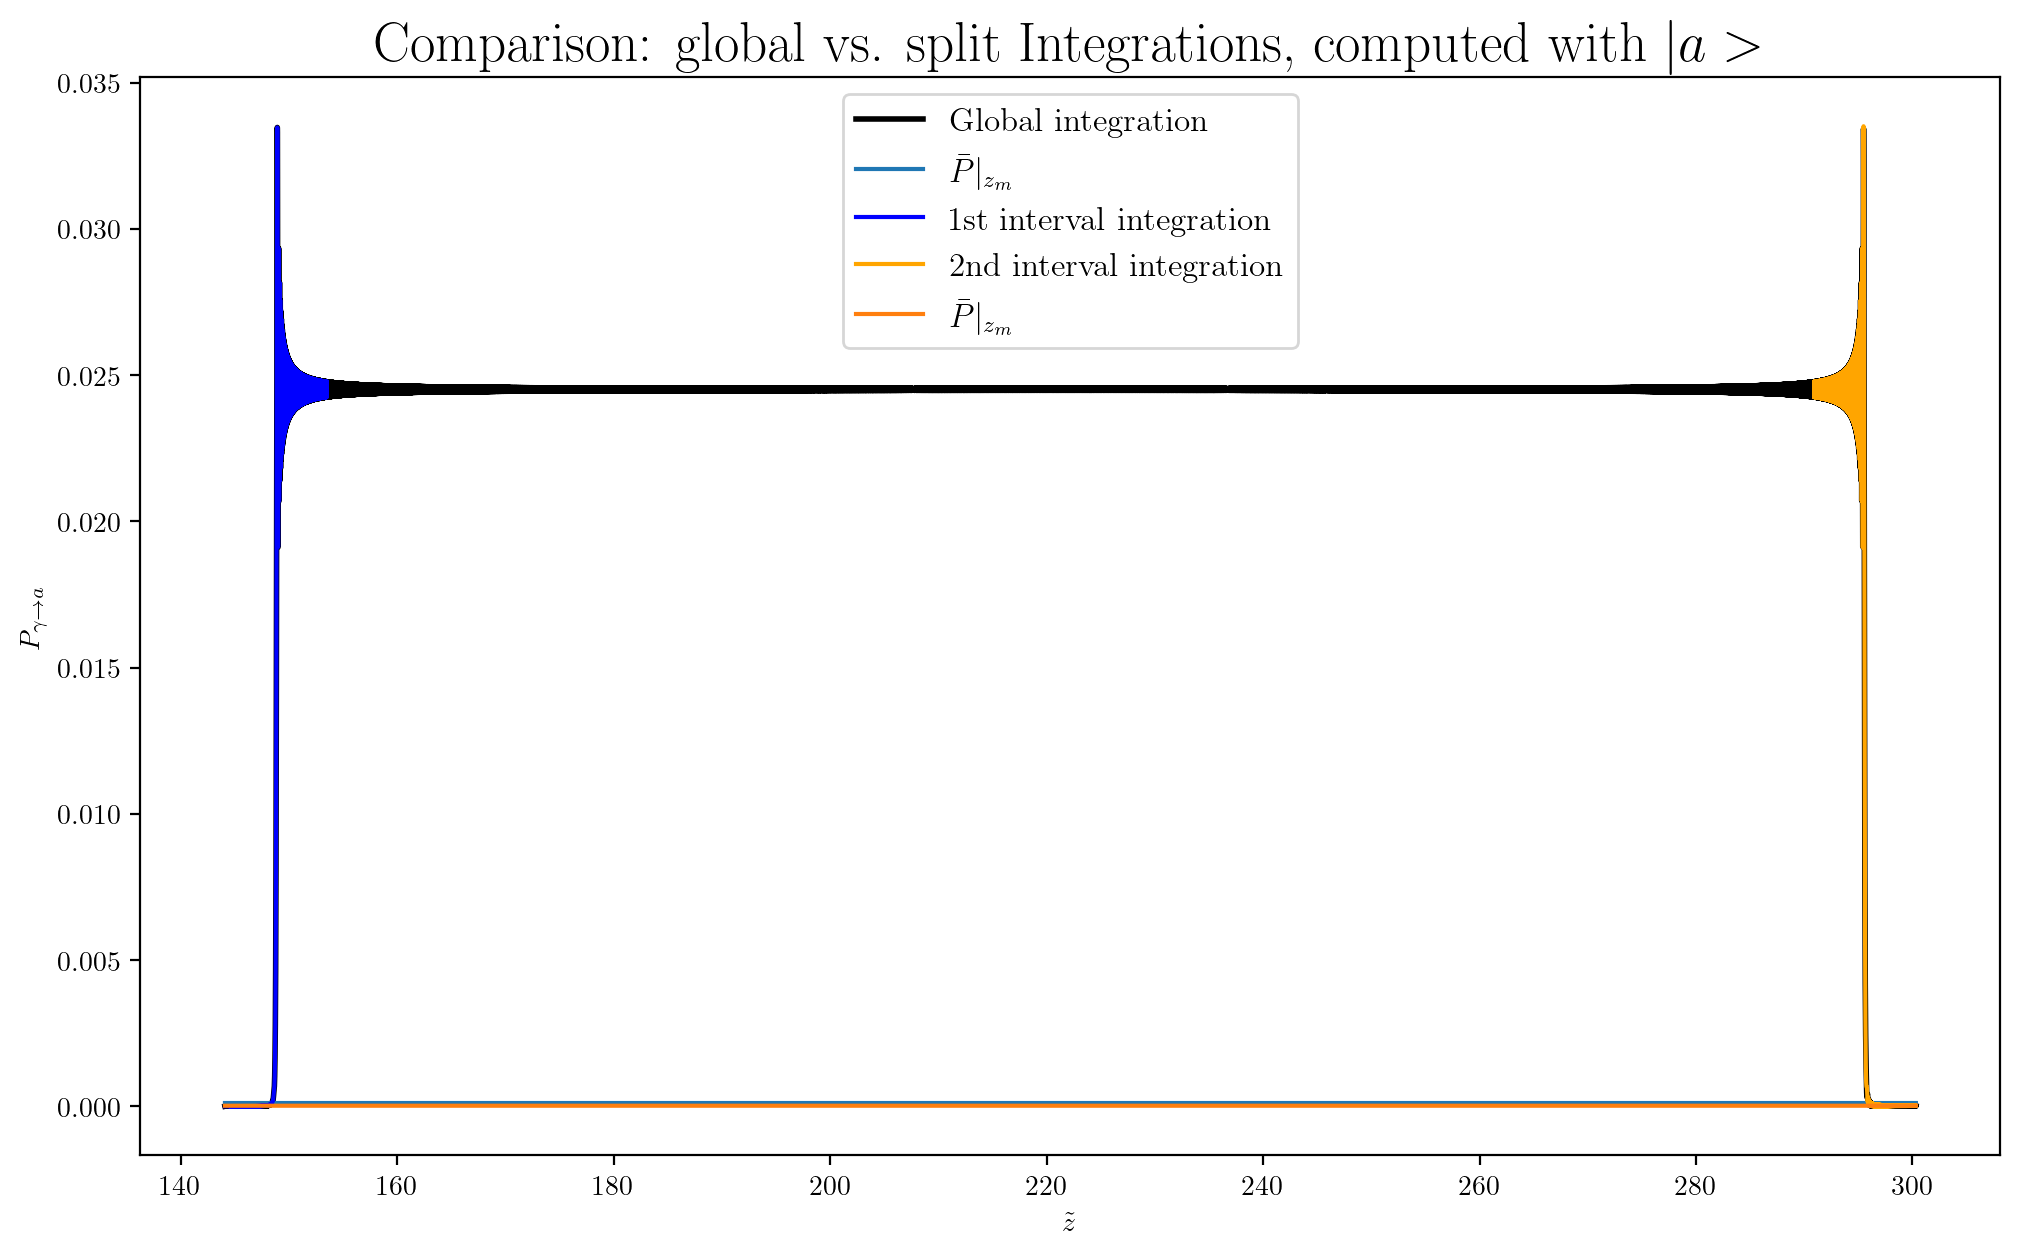

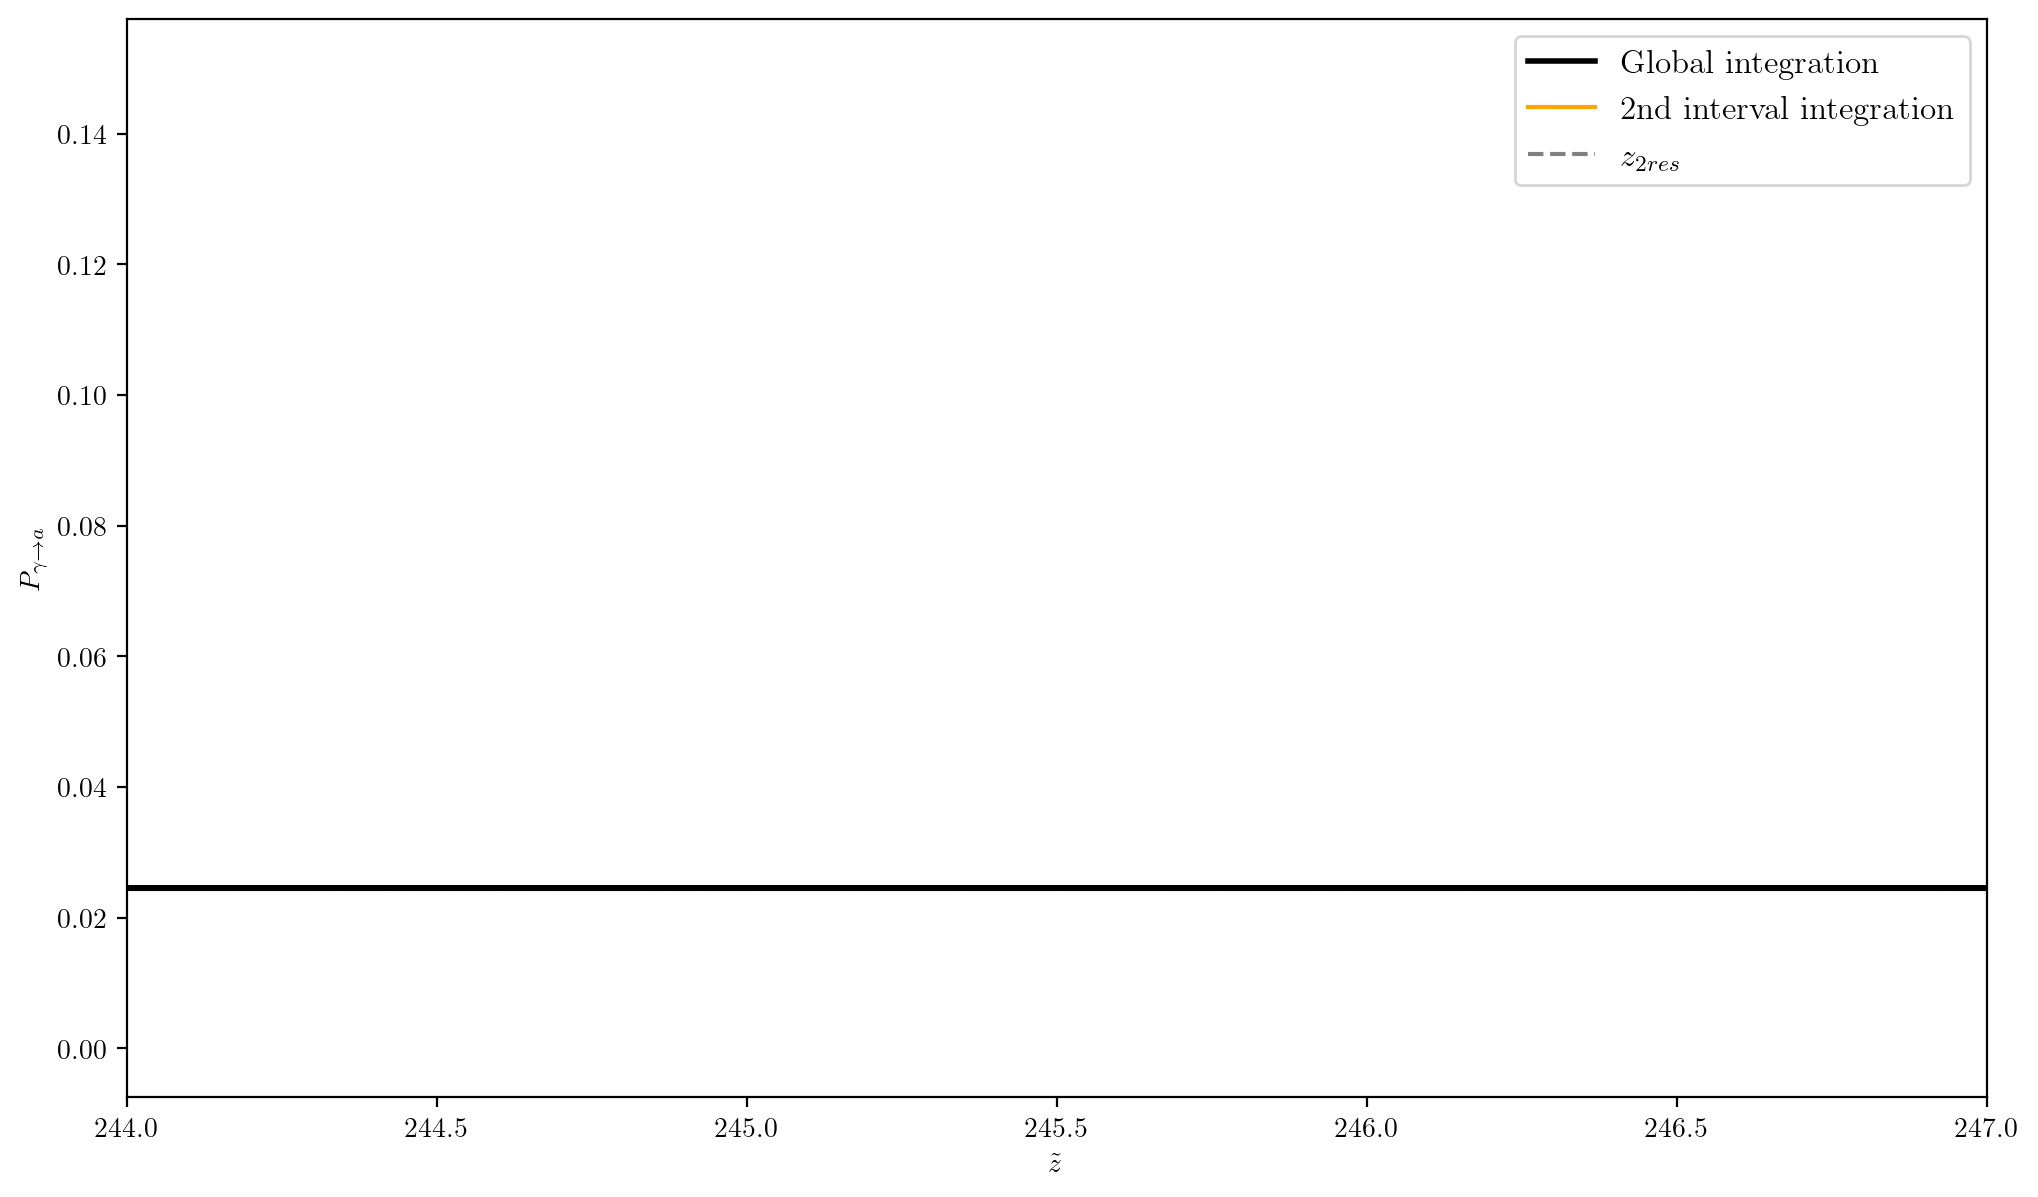

In [37]:
############################################################################
# Plotting global vs cut integration and zooming in the 2nd region for |a>
############################################################################


plt.figure(figsize=(12, 7))

# Global integration
plt.plot(z_tilde_thr_cut, p_LZ_1_increasing_decreasing, label='Global integration', color='black', linewidth=2)
plt.plot(z_tilde_thr_cut,P_mean_value_2nd_res*np.ones_like(z_tilde_thr_cut), label=r'$\bar{P}|_{z_m}$')

# First interval integration
plt.plot(z_tilde_thr_cut1, p_LZ_1_increasing_decreasing1, label='1st interval integration', linestyle='-', color='blue')

# Second interval integration
P_mean_value_2nd_res2 = np.mean(p_LZ_1_increasing_decreasing2[750000:])
plt.plot(z_tilde_thr_cut2, p_LZ_1_increasing_decreasing2, label='2nd interval integration', linestyle='-', color='orange')
plt.plot(z_tilde_thr_cut,P_mean_value_2nd_res2*np.ones_like(z_tilde_thr_cut), label=r'$\bar{P}|_{z_m}$')
#plt.plot(z_tilde_thr_cut,2*np.pi*gamma_factor[index_res1]*np.ones_like(z_tilde_thr_cut) * factor, label=r'Analitical')


plt.xlabel(r'$\tilde{z}$')
plt.ylabel(r'$P_{\gamma \rightarrow a}$')
plt.title('Comparison: global vs. split Integrations, computed with $|a>$', fontsize= '20')
plt.legend(fontsize=12)
plt.show()


#Zooming in on the 2nd region

plt.figure(figsize=(12, 7))
plt.plot(z_tilde_thr_cut, p_LZ_1_increasing_decreasing, label='Global integration', color='black', linewidth=2)
plt.plot(z_tilde_thr_cut2, p_LZ_1_increasing_decreasing2, label='2nd interval integration', linestyle='-', color='orange')
z_n_line = plt.vlines(z_tilde_thr_cut[index_res2_cut], 0,0.15, linestyle='dashed', color='gray', label=r'$z_{2res}$')
plt.xlim(244,247)
plt.xlabel(r'$\tilde{z}$')
plt.ylabel(r'$P_{\gamma \rightarrow a}$')
plt.legend(fontsize=12)
plt.show()

In [38]:
#Differences between the two kind of integrations 

Difference =np.abs( (P_mean_value_2nd_res-P_mean_value_2nd_res2)/P_mean_value_2nd_res)
Difference

0.8387910085283401

# $\ket{u}$ implementation

Here we want to implement our code from $\ket{a}$ to $\ket{u}$ and work with the latter, solving the correspective ODE. 

In [39]:
################################################################
# Defining the solver for the photon-to-axion equation for |u>
################################################################

Delta_parallel_tilde_cut_vals = np.interp(z_tilde_thr_cut, z_tilde_thr, Delta_parallel_tilde_vals)
spline_Delta_par_cut = UnivariateSpline(z_tilde_thr_cut, Delta_parallel_tilde_cut_vals, s=0)
dDelta_parallel_tilde_cut_vals = spline_Delta_par_cut.derivative()(z_tilde_thr_cut)


@njit
def master_eq_LZ_1_numba_u(z, S, z_tilde_vals, Delta_parallel_tilde_vals, Delta_a_val, Delta_ag_val,dDelta_parallel_tilde_cut_vals):
    u, f = S[0], S[1]

    # Interpolation of Delta_parallel_tilde and its derivative
    Delta_parallel_tilde_interp = np.interp(z, z_tilde_vals, Delta_parallel_tilde_vals)
    dDelta_parallel_tilde_interp = np.interp(z, z_tilde_vals, dDelta_parallel_tilde_cut_vals)

    # Defining the ODE for |u>
    dSdz_0 = f
    dSdz_1 = -1*( 1+ 1/4 * ((Delta_parallel_tilde_interp - Delta_a_val) / Delta_ag_val)**2 - 1j*0.5* dDelta_parallel_tilde_interp/Delta_ag_val) *  u
    
    return np.array([dSdz_0, dSdz_1], dtype=np.complex128)



In [40]:
##################################################
# Solving the equation for |u> on z_tilde_thr_cut 
##################################################

def wrapper_master_eq_u(z, S):
    return master_eq_LZ_1_numba_u(
        z,
        S,
        z_tilde_thr_cut,
        Delta_parallel_tilde_cut_vals,
        Delta_a_value,
        Delta_ag_value,
        dDelta_parallel_tilde_cut_vals
    )
    

#Initial conditions for the ODE
ic_LZ_u = np.array([0, -1j], dtype=np.complex128)

sol_LZ_1_increasing_decreasing_u = solve_ivp(
    wrapper_master_eq_u,
    (z_tilde_thr_cut[0], z_tilde_thr_cut[-1]),
    ic_LZ_u,
    method='DOP853',
    t_eval=z_tilde_thr_cut,
    rtol=1e-8,
    atol=1e-10
)

p_LZ_1_increasing_decreasing_u = np.abs(sol_LZ_1_increasing_decreasing_u.y[0])**2

In [41]:
##################################################################
# Computing the cut solution (on the same two intervals) for |u>
##################################################################

# Interval 1:
 
Delta_parallel_tilde_cut_vals1 = np.interp(z_tilde_thr_cut1, z_tilde_thr, Delta_parallel_tilde_vals)
spline_Delta_par_cut1 = UnivariateSpline(z_tilde_thr_cut1, Delta_parallel_tilde_cut_vals1, s=0)
dDelta_parallel_tilde_cut_vals1 = spline_Delta_par_cut1.derivative()(z_tilde_thr_cut1)


ic_LZ1_u = np.array([0, -1j], dtype=np.complex128)

def wrapper_master_eq1_u(z, S):
    return master_eq_LZ_1_numba_u(
        z,
        S,
        z_tilde_thr_cut1,
        Delta_parallel_tilde_cut_interp1,
        Delta_a_value,
        Delta_ag_value,
        dDelta_parallel_tilde_cut_vals1
    )
    
sol_LZ_1_increasing_decreasing1_u = solve_ivp(
    wrapper_master_eq1_u,
    (z_tilde_thr_cut1[0], z_tilde_thr_cut1[-1]),
    ic_LZ1_u,
    method='DOP853',
    t_eval=z_tilde_thr_cut1,
    rtol=1e-8,
    atol=1e-10
)

p_LZ_1_increasing_decreasing1_u = np.abs(sol_LZ_1_increasing_decreasing1_u.y[0])**2


# Interval 2:


Delta_parallel_tilde_cut_vals2 = np.interp(z_tilde_thr_cut2, z_tilde_thr, Delta_parallel_tilde_vals)
spline_Delta_par_cut2 = UnivariateSpline(z_tilde_thr_cut2, Delta_parallel_tilde_cut_vals2, s=0)
dDelta_parallel_tilde_cut_vals2 = spline_Delta_par_cut2.derivative()(z_tilde_thr_cut2)


ic_LZ2_u = np.array([ sol_LZ_1_increasing_decreasing1_u.y[0][-1], sol_LZ_1_increasing_decreasing1_u.y[1][-1] ], dtype=np.complex128)

def wrapper_master_eq2_u(z, S):
    return master_eq_LZ_1_numba_u(
        z,
        S,
        z_tilde_thr_cut2,
        Delta_parallel_tilde_cut_interp2,
        Delta_a_value,
        Delta_ag_value,
        dDelta_parallel_tilde_cut_vals2
    )
    
sol_LZ_1_increasing_decreasing2_u = solve_ivp(
    wrapper_master_eq2_u,
    (z_tilde_thr_cut2[0], z_tilde_thr_cut2[-1]),
    ic_LZ2_u,
    method='DOP853',
    t_eval=z_tilde_thr_cut2,
    rtol=1e-8,
    atol=1e-10
)

p_LZ_1_increasing_decreasing2_u = np.abs(sol_LZ_1_increasing_decreasing2_u.y[0])**2


/opt/miniconda3/envs/cosmo_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/cosmo_env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/miniconda3/envs/cosmo_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


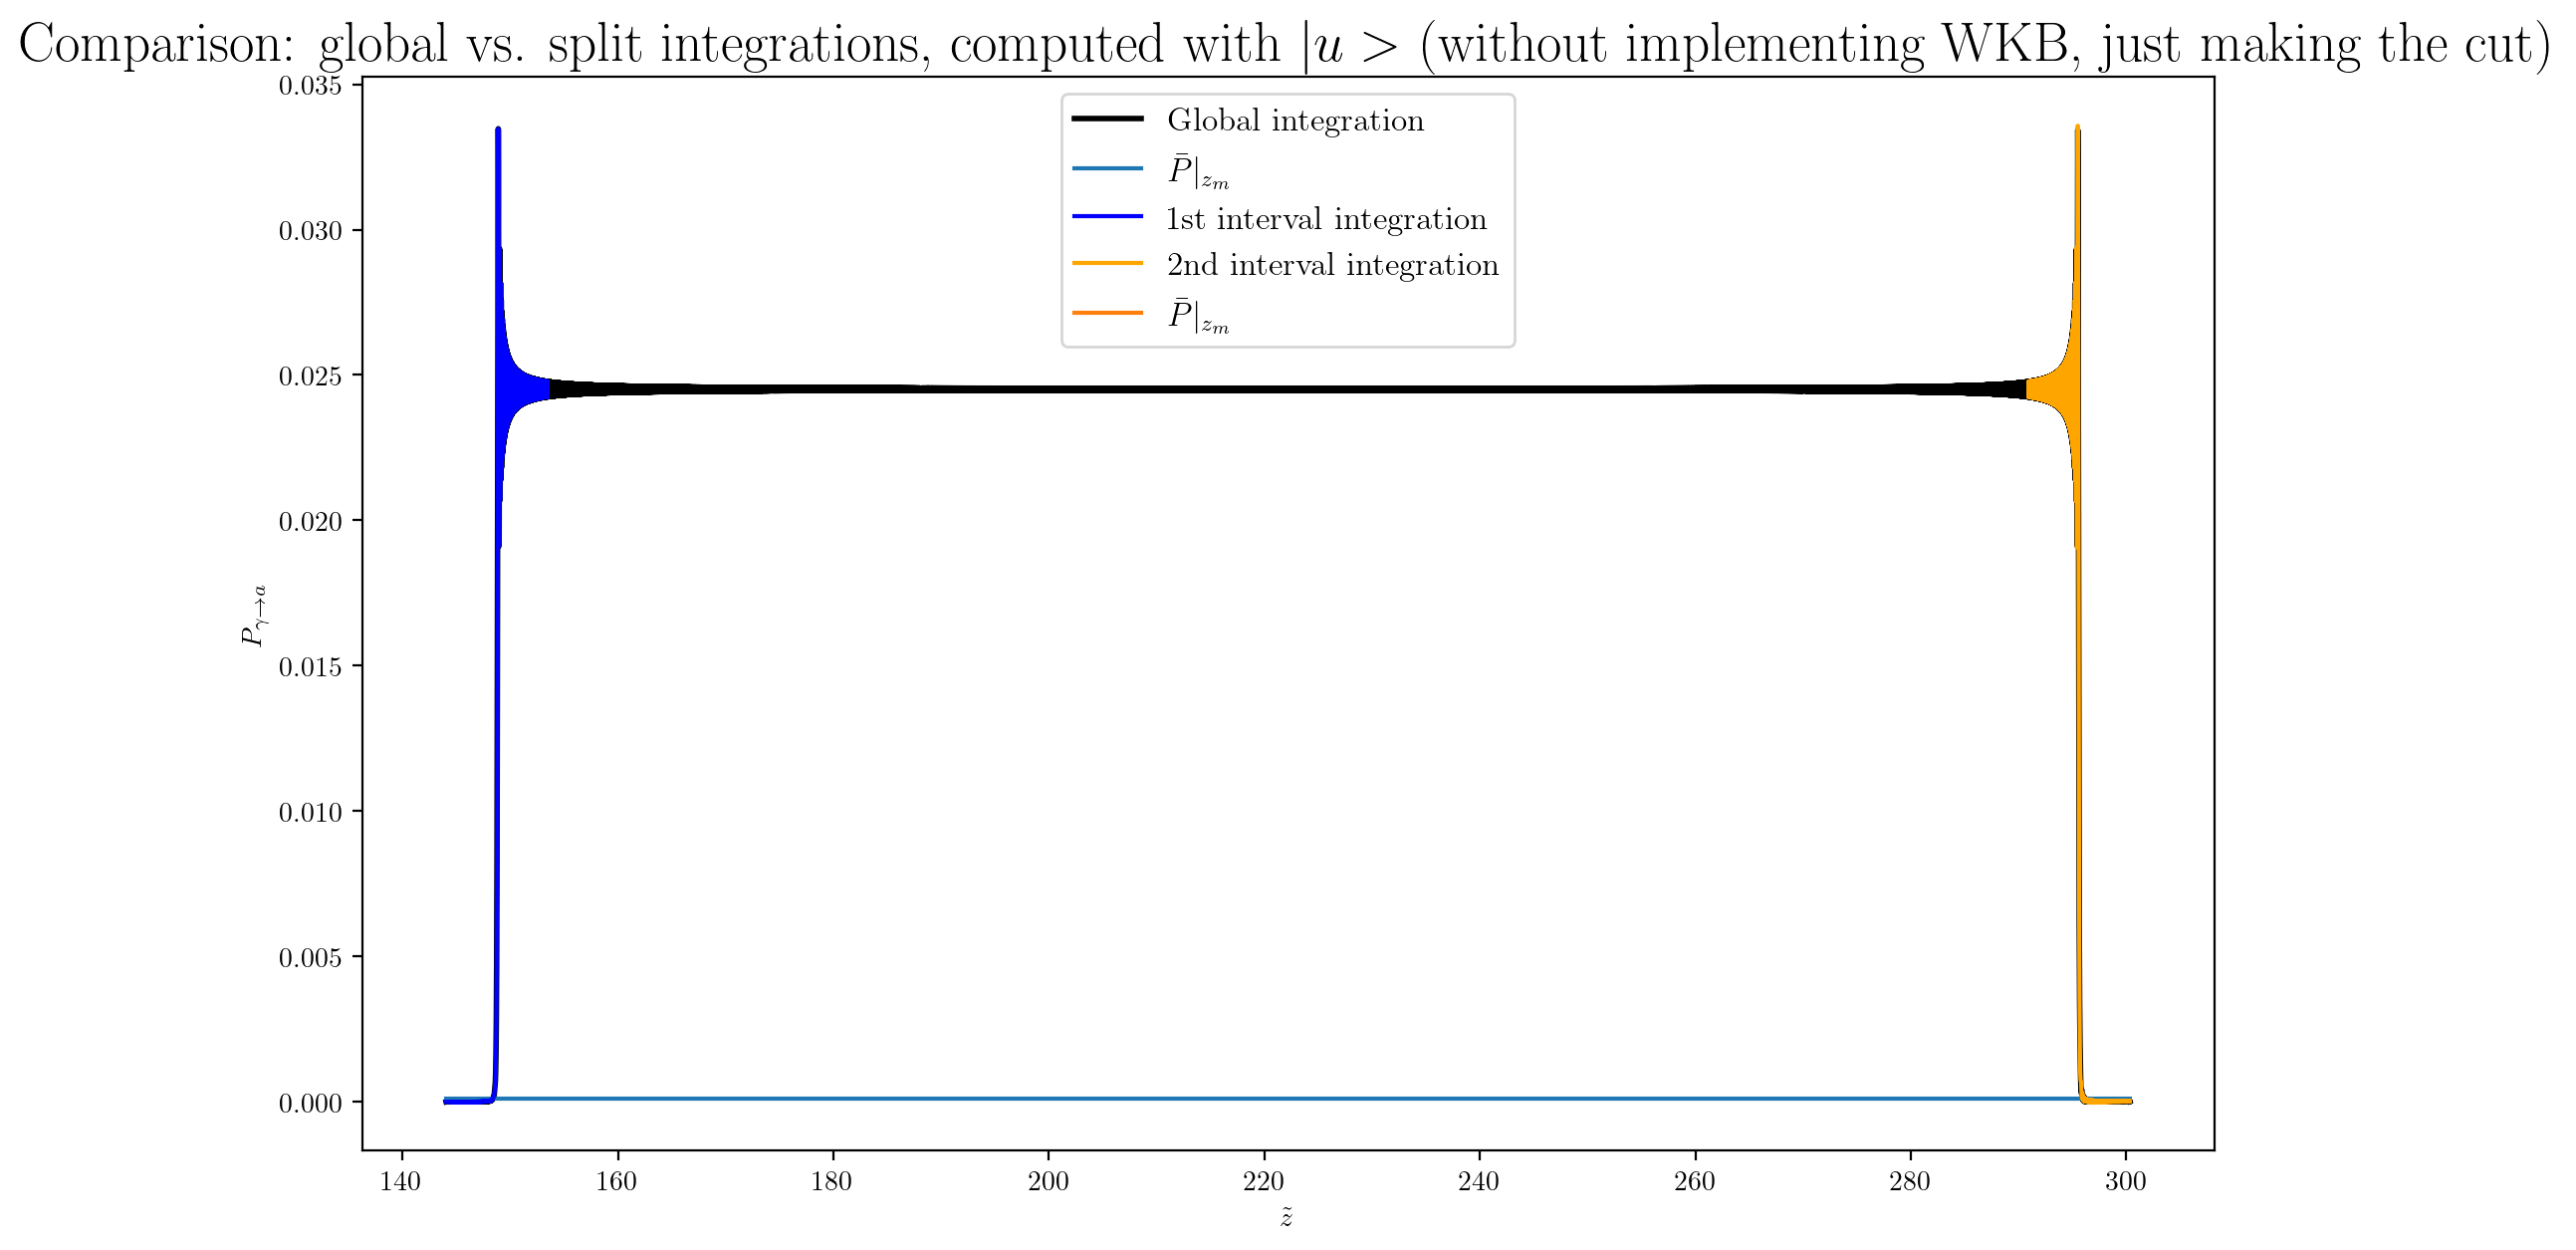

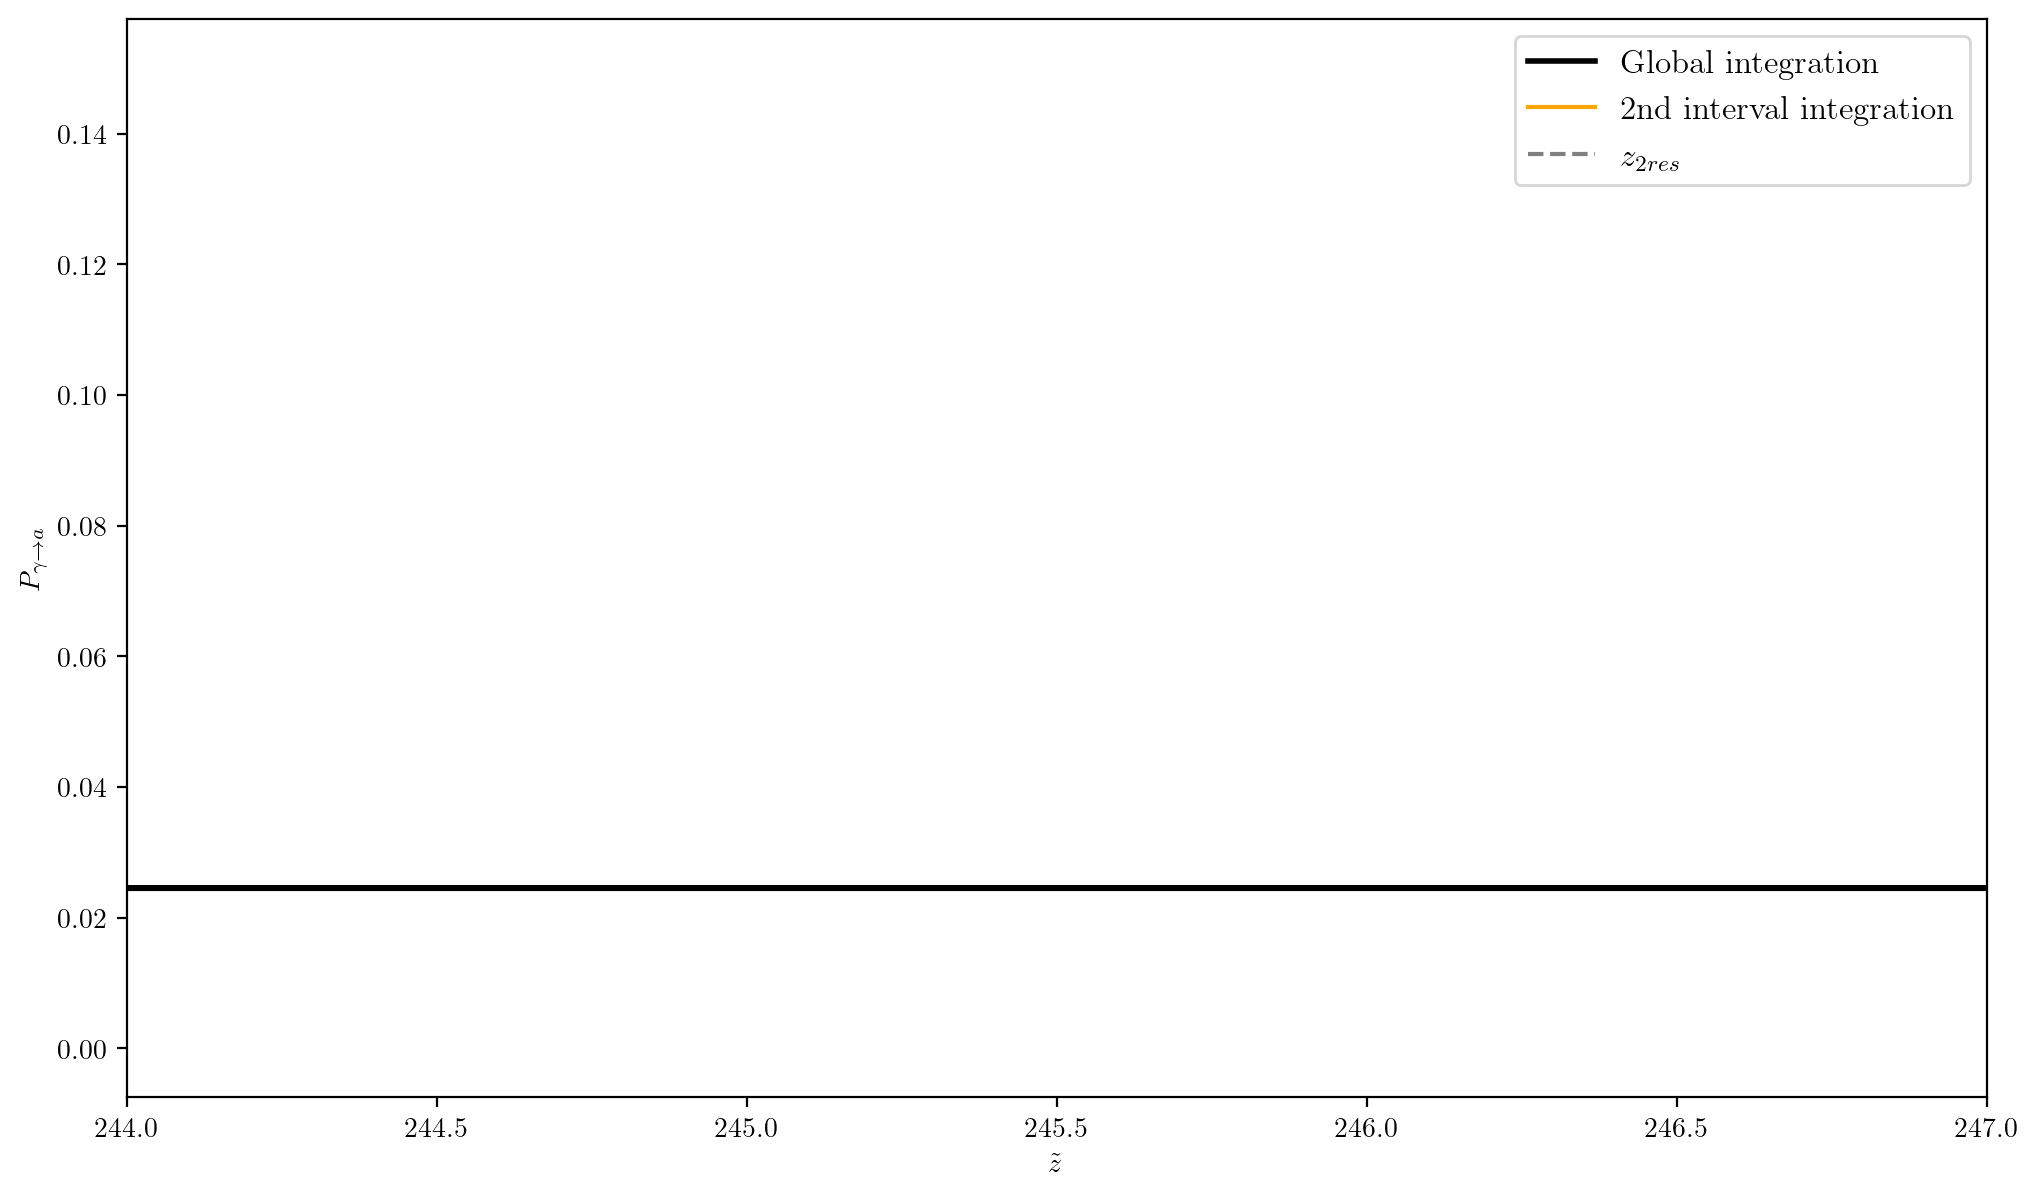

In [42]:
############################################################################
# Plotting global vs cut integration and zooming in the 2nd region for |u>
############################################################################


plt.figure(figsize=(12, 7))

# Global integration
plt.plot(z_tilde_thr_cut, p_LZ_1_increasing_decreasing_u, label='Global integration', color='black', linewidth=2)
plt.plot(z_tilde_thr_cut,P_mean_value_2nd_res*np.ones_like(z_tilde_thr_cut), label=r'$\bar{P}|_{z_m}$')

# First interval integration
plt.plot(z_tilde_thr_cut1, p_LZ_1_increasing_decreasing1_u, label='1st interval integration', linestyle='-', color='blue')

# Second interval integration
P_mean_value_2nd_res2 = np.mean(p_LZ_1_increasing_decreasing2[7500000:])
plt.plot(z_tilde_thr_cut2, p_LZ_1_increasing_decreasing2_u, label='2nd interval integration', linestyle='-', color='orange')
plt.plot(z_tilde_thr_cut,P_mean_value_2nd_res2*np.ones_like(z_tilde_thr_cut), label=r'$\bar{P}|_{z_m}$')
#plt.plot(z_tilde_thr_cut,2*np.pi*gamma_factor[index_res1]*np.ones_like(z_tilde_thr_cut) * factor, label=r'Analitical')


plt.xlabel(r'$\tilde{z}$')
plt.ylabel(r'$P_{\gamma \rightarrow a}$')
plt.title('Comparison: global vs. split integrations, computed with $|u>$ (without implementing WKB, just making the cut) ', fontsize= '20')
plt.legend(fontsize=12)
plt.show()


#Zooming in on the 2nd region

plt.figure(figsize=(12, 7))
plt.plot(z_tilde_thr_cut, p_LZ_1_increasing_decreasing_u, label='Global integration', color='black', linewidth=2)
plt.plot(z_tilde_thr_cut2, p_LZ_1_increasing_decreasing2_u, label='2nd interval integration', linestyle='-', color='orange')
z_n_line = plt.vlines(z_tilde_thr_cut[index_res2_cut], 0,0.15, linestyle='dashed', color='gray', label=r'$z_{2res}$')
plt.xlim(244,247)
plt.xlabel(r'$\tilde{z}$')
plt.ylabel(r'$P_{\gamma \rightarrow a}$')
plt.legend(fontsize=12)
plt.show()

# WKB

Here we implement the WKB solution to propagate the solution from $z_1^{max}$ to $z_2^{min}$. The WKB solution in therefore implemented on the interval z_grid.

In [43]:
#########################################
# Computing the quantities on the grid
#########################################

Delta_parallel_vals_interp = np.interp(z_grid, z_tilde_thr, Delta_parallel_tilde_vals)
Delta_parallel_minus_Delta_a_grid = Delta_parallel_vals_interp - Delta_a_value

# Cumulative integral of the WKB phase
phase_integrand = Delta_parallel_minus_Delta_a_grid / Delta_ag_value
phi_cumulative = cumulative_trapezoid(phase_integrand, z_grid, initial=0)

In [44]:
####################################################
# Computing the quantities in u_WKB and du/dz|_WKB
####################################################

#Phase's derivatives

Dphi = (Delta_parallel_vals_interp-Delta_a_value)/Delta_ag_value
spline_Dphi = UnivariateSpline(z_grid, Dphi, s=0) 
DDphi = spline_Dphi.derivative(n=1)(z_grid)   
DDDphi = spline_Dphi.derivative(n=2)(z_grid) 

#Other quantities:

abs_k_1_max = ( (1+ Dphi[0]**2/4)**2 - DDphi[0]**2 /4 )**(1/4)

k_1_max = np.sqrt(1+ Dphi[0]**2/4 - 1j*DDphi[0]/2 )

Dk_1_max = 1/(2 * k_1_max) * ( (Dphi[0] * DDphi[0])/2  - 1j*DDDphi[0]/2 )

A_plus_1_max = -0.5 * (np.real(k_1_max)*np.real(Dk_1_max) + np.imag(k_1_max)*np.imag(Dk_1_max) )/(abs_k_1_max**(5/2)) + 1j *k_1_max/(abs_k_1_max**(1/2))

A_minus_1_max = -0.5 * (np.real(k_1_max)*np.real(Dk_1_max) + np.imag(k_1_max)*np.imag(Dk_1_max) )/(abs_k_1_max**(5/2)) - 1j *k_1_max/(abs_k_1_max**(1/2))

In [45]:
########################################################
# Solving the two-equations system to find C_+ and C_-
########################################################

#Defining the quantities at z_1^max from the numerical solution on the first cut interval
u_1_max =  sol_LZ_1_increasing_decreasing1_u.y[0][-1]
Du_1_max = sol_LZ_1_increasing_decreasing1_u.y[1][-1]
sqrt_k = np.sqrt(abs_k_1_max)

#Solving the system 

M = np.array([
    [1 / sqrt_k, 1 / sqrt_k],
    [A_plus_1_max, A_minus_1_max]
])

b = np.array([u_1_max, Du_1_max])

C_plus, C_minus = np.linalg.solve(M, b)

In [46]:
####################################
# Testing how good C_+ and C_- are
####################################

print( ((C_plus+C_minus)/sqrt_k) - sol_LZ_1_increasing_decreasing1_u.y[0][-1])

print( (C_plus*A_plus_1_max + C_minus*A_minus_1_max)  -  sol_LZ_1_increasing_decreasing1_u.y[1][-1])


-3.469446951953614e-18j
(1.7763568394002505e-15+0j)


In [47]:
###################################################
# Defining u_WKB and evolving it across z_grid
###################################################


k_z =  np.sqrt(1+ Dphi**2/4 - 1j*DDphi/2 )

Phase_grid = simpson(k_z, z_grid) #Phase in u_WKB

Phase_cumulative_grid = cumulative_trapezoid(k_z, z_grid, initial=0)

u_WKB = (C_plus *np.exp(+1j*Phase_cumulative_grid) + C_minus *np.exp(-1j*Phase_cumulative_grid))/( (1+ Dphi**2/4)**2 - DDphi**2/4 )**(1/8)


In [48]:
##########################################
# Computing du/dz|_WKB separating u_WKB
##########################################


u_real = np.real(u_WKB)
u_imag = np.imag(u_WKB)

spline_real = UnivariateSpline(z_grid, u_real, s=0)
spline_imag = UnivariateSpline(z_grid, u_imag, s=0)

Du_real = spline_real.derivative(n=1)(z_grid)
Du_imag = spline_imag.derivative(n=1)(z_grid)


Du_WKB = Du_real + 1j * Du_imag

In [49]:
###############################################################################
# Computing z_2^min index on z_grid to compute u_WKB and Du_WKB at that point
###############################################################################

idx_z2grid = np.argmin(np.abs(z_grid - z_tilde_thr_cut2_min))
print(idx_z2grid)
print(z_grid[idx_z2grid])

4999986
290.9234692249503


In [50]:
##########################################################################################
# Integrating over the second interval setting the IC from u_WKB and Du_WKB at z_2^min
##########################################################################################

# New IC on the 2nd interval, computed with the u_WKB and Du_WKB
ic_LZ2_u = np.array([  u_WKB[idx_z2grid], Du_WKB[idx_z2grid] ], dtype=np.complex128)

def wrapper_master_eq2_u(z, S):
    return master_eq_LZ_1_numba_u(
        z,
        S,
        z_tilde_thr_cut2,
        Delta_parallel_tilde_cut_interp2,
        Delta_a_value,
        Delta_ag_value,
        dDelta_parallel_tilde_cut_vals2
    )
    
sol_LZ_1_increasing_decreasing2_u = solve_ivp(
    wrapper_master_eq2_u,
    (z_tilde_thr_cut2[0], z_tilde_thr_cut2[-1]),
    ic_LZ2_u,
    method='DOP853',
    t_eval=z_tilde_thr_cut2,
    rtol=1e-8,
    atol=1e-10
)

#Here we upload the previous-computed solution on the 2nd interval
p_LZ_1_increasing_decreasing2_u = np.abs(sol_LZ_1_increasing_decreasing2_u.y[0])**2

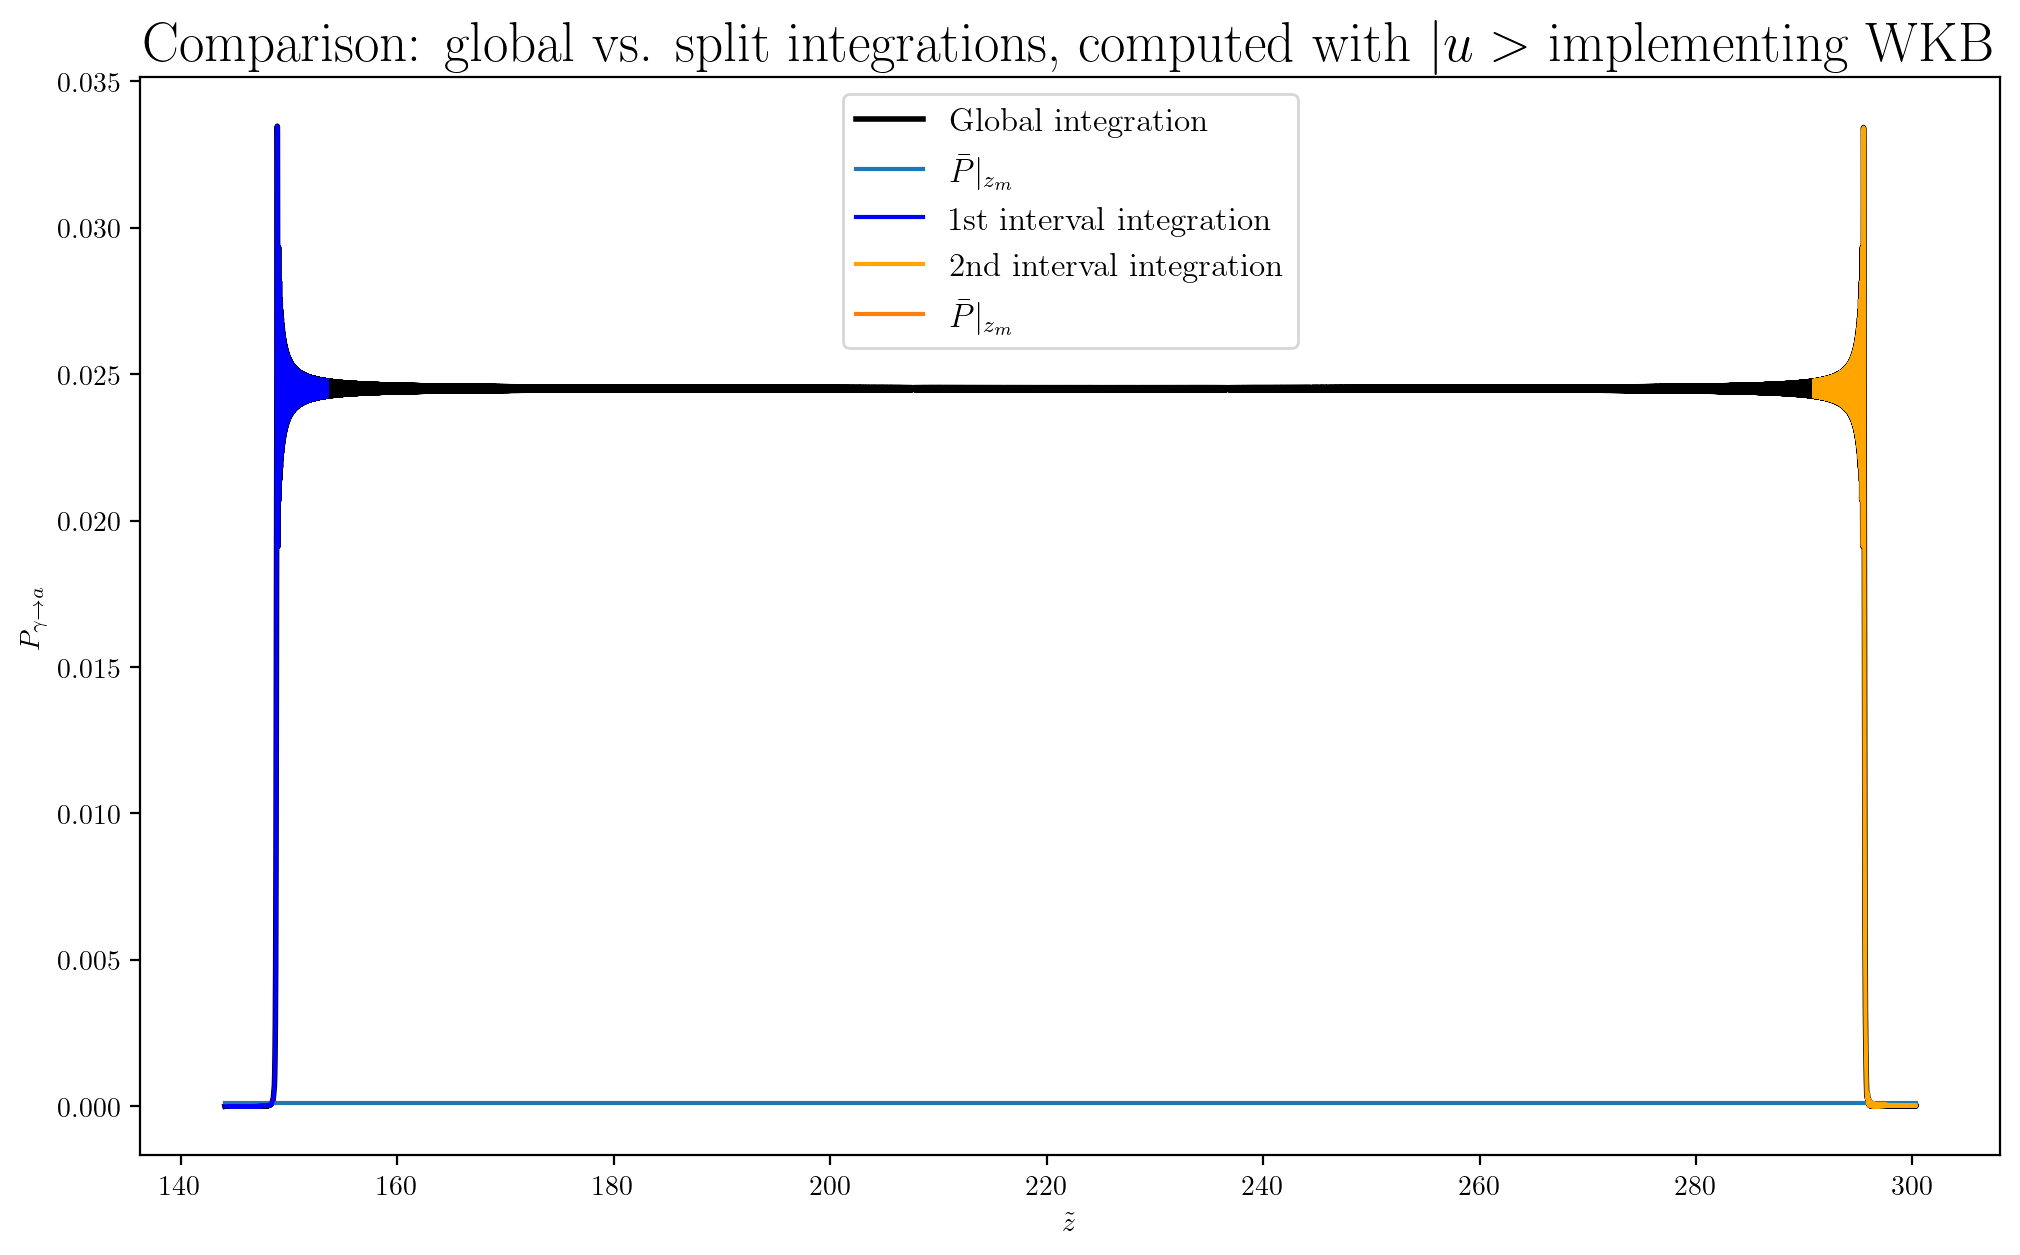

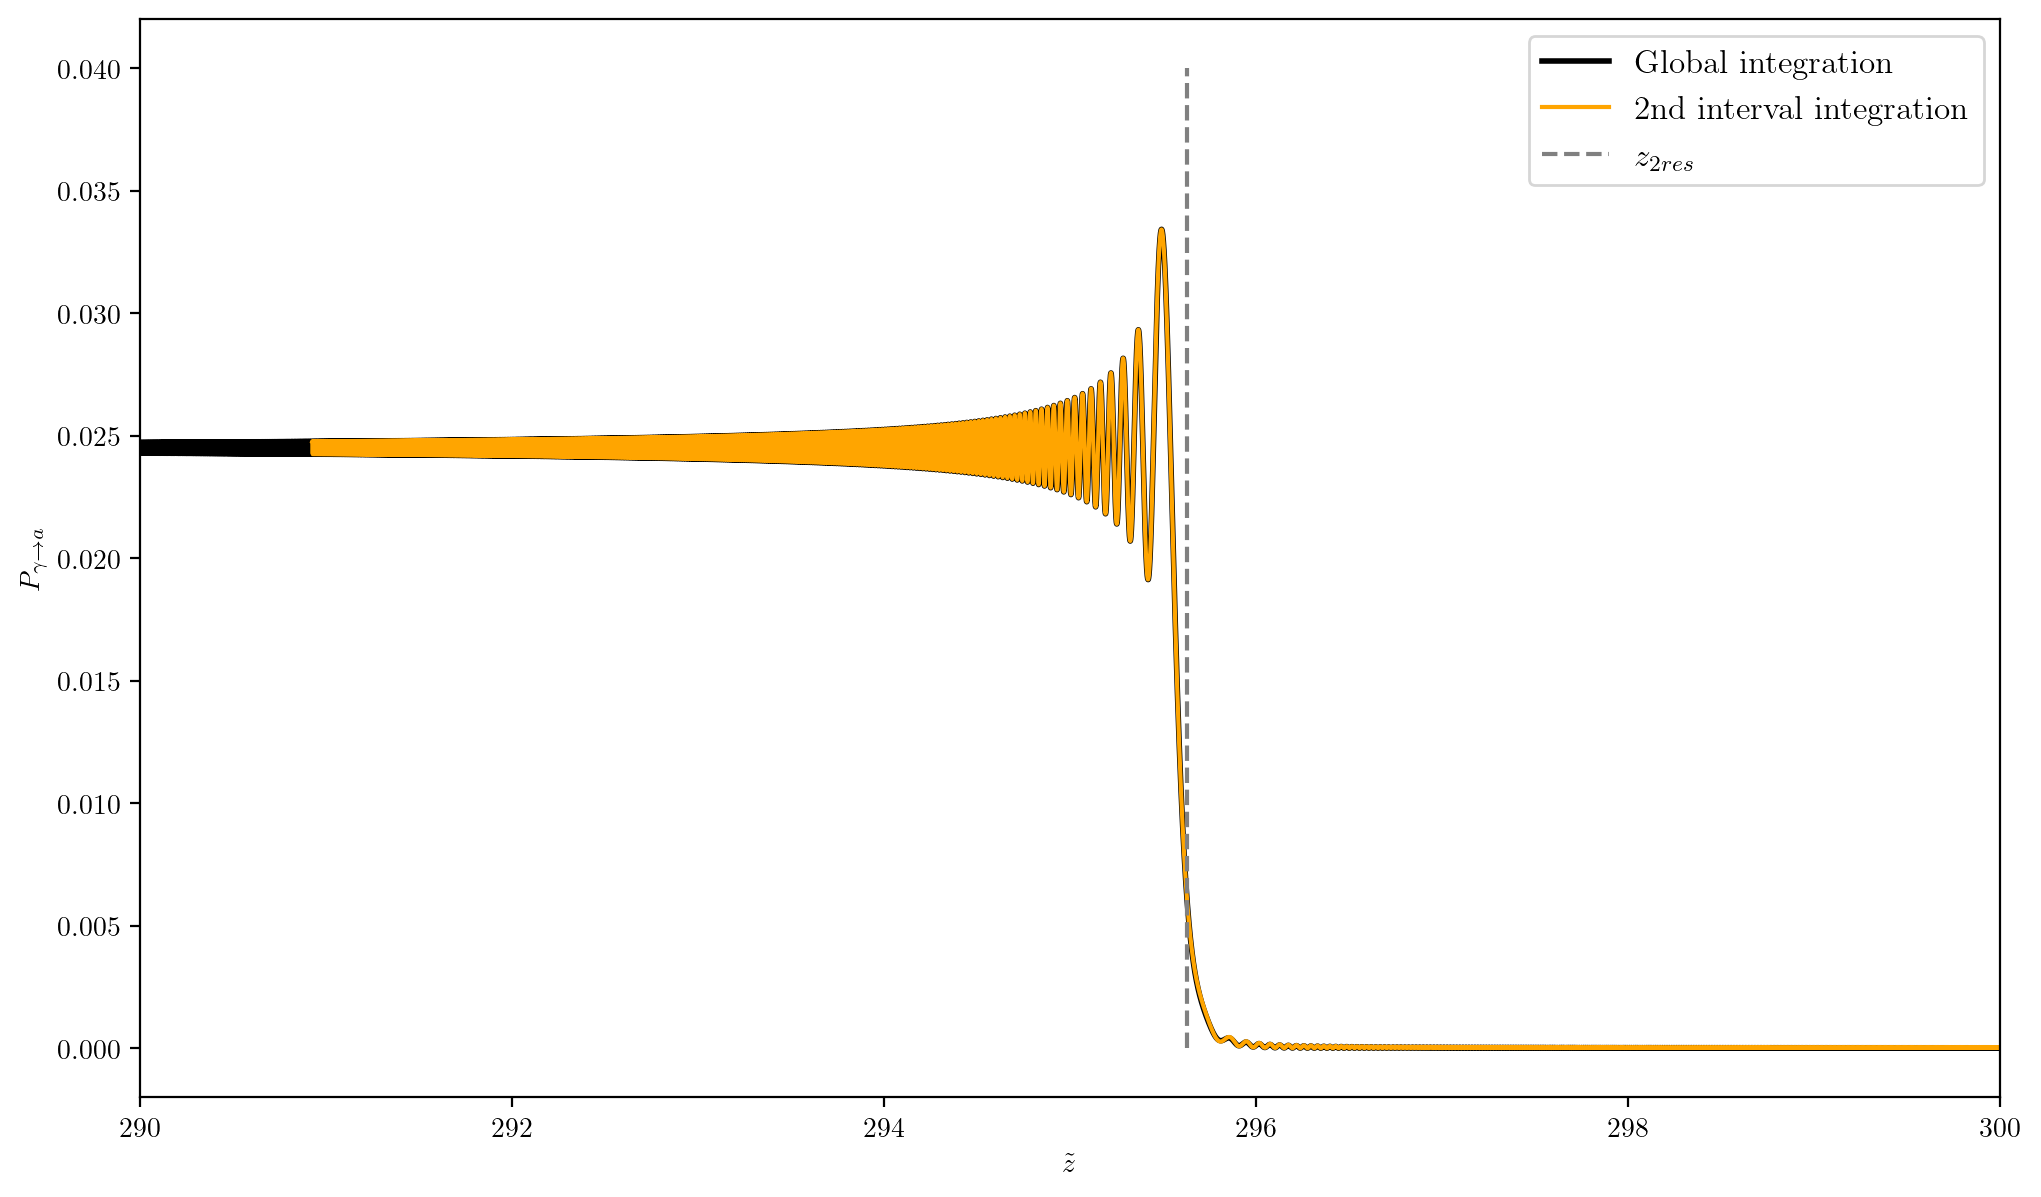

In [62]:
############################################################################
# Plotting global vs cut integration and zooming in the 2nd region for |u>
############################################################################


plt.figure(figsize=(12, 7))

# Global integration
plt.plot(z_tilde_thr_cut, p_LZ_1_increasing_decreasing_u, label='Global integration', color='black', linewidth=2)
plt.plot(z_tilde_thr_cut,P_mean_value_2nd_res*np.ones_like(z_tilde_thr_cut), label=r'$\bar{P}|_{z_m}$')

# First interval integration
plt.plot(z_tilde_thr_cut1, p_LZ_1_increasing_decreasing1_u, label='1st interval integration', linestyle='-', color='blue')

# Second interval integration
P_mean_value_2nd_res2 = np.mean(p_LZ_1_increasing_decreasing2[7500000:])
plt.plot(z_tilde_thr_cut2, p_LZ_1_increasing_decreasing2_u, label='2nd interval integration', linestyle='-', color='orange')
plt.plot(z_tilde_thr_cut,P_mean_value_2nd_res2*np.ones_like(z_tilde_thr_cut), label=r'$\bar{P}|_{z_m}$')
#plt.plot(z_tilde_thr_cut,2*np.pi*gamma_factor[index_res1]*np.ones_like(z_tilde_thr_cut) * factor, label=r'Analitical')


plt.xlabel(r'$\tilde{z}$')
plt.ylabel(r'$P_{\gamma \rightarrow a}$')
plt.title('Comparison: global vs. split integrations, computed with $|u>$ implementing WKB', fontsize= '20')
plt.legend(fontsize=12)
plt.show()


#Zooming in on the 2nd region

plt.figure(figsize=(12, 7))
plt.plot(z_tilde_thr_cut, p_LZ_1_increasing_decreasing_u, label='Global integration', color='black', linewidth=2)
plt.plot(z_tilde_thr_cut2, p_LZ_1_increasing_decreasing2_u, label='2nd interval integration', linestyle='-', color='orange')
z_n_line = plt.vlines(z_tilde_thr_cut[index_res2_cut], 0,0.04, linestyle='dashed', color='gray', label=r'$z_{2res}$')
plt.xlim(290,300)
plt.xlabel(r'$\tilde{z}$')
plt.ylabel(r'$P_{\gamma \rightarrow a}$')
plt.legend(fontsize=12)
plt.show()

# Tests 

## Test 1: are the global integrations equal each other? 

Text(0.5, 1.0, 'P computed with $|a>$ vs computed with $|u>$')

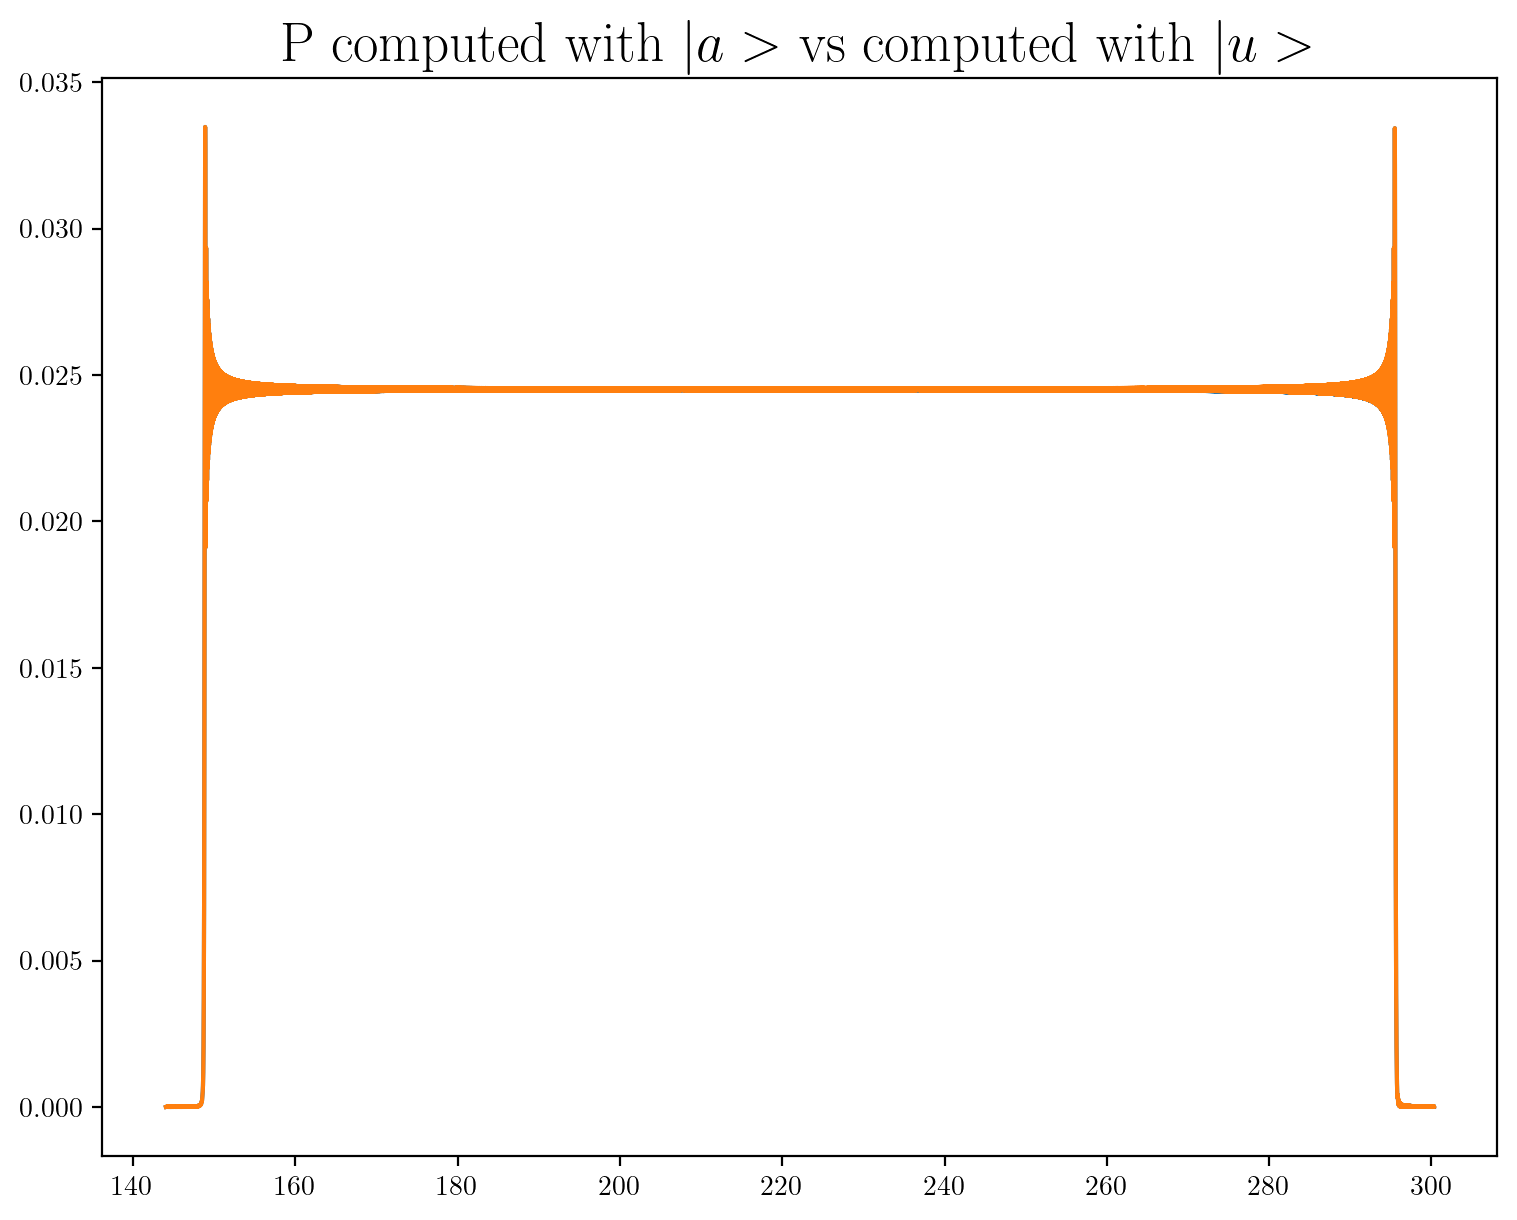

In [52]:
#######################################################
# Comparison btw the global solution in |a> vs in |u>
#######################################################

plt.plot(z_tilde_thr_cut, p_LZ_1_increasing_decreasing_u)
plt.plot(z_tilde_thr_cut, p_LZ_1_increasing_decreasing)
plt.title('P computed with $|a>$ vs computed with $|u>$', fontsize= '20')

## Test 2: are the $\ket{a}$ and $\ket{u}$ solutions equivalent each other? 

If so, we should be able to recover $\ket{u}$ from $\ket{a}$ and vice-versa. To do so, let's apply the transformation $\ket{a} = e^{-i\phi/2} \ket{u}$ to check if actually we can recover $\ket{a}$ from $\ket{u}$. 

In [53]:
fase = (Delta_parallel_tilde_cut_interp - Delta_a_value)/Delta_ag_value
phi_cumulative_cut = cumulative_trapezoid(fase, z_tilde_thr_cut, initial=0)

/opt/miniconda3/envs/cosmo_env/lib/python3.11/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/miniconda3/envs/cosmo_env/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


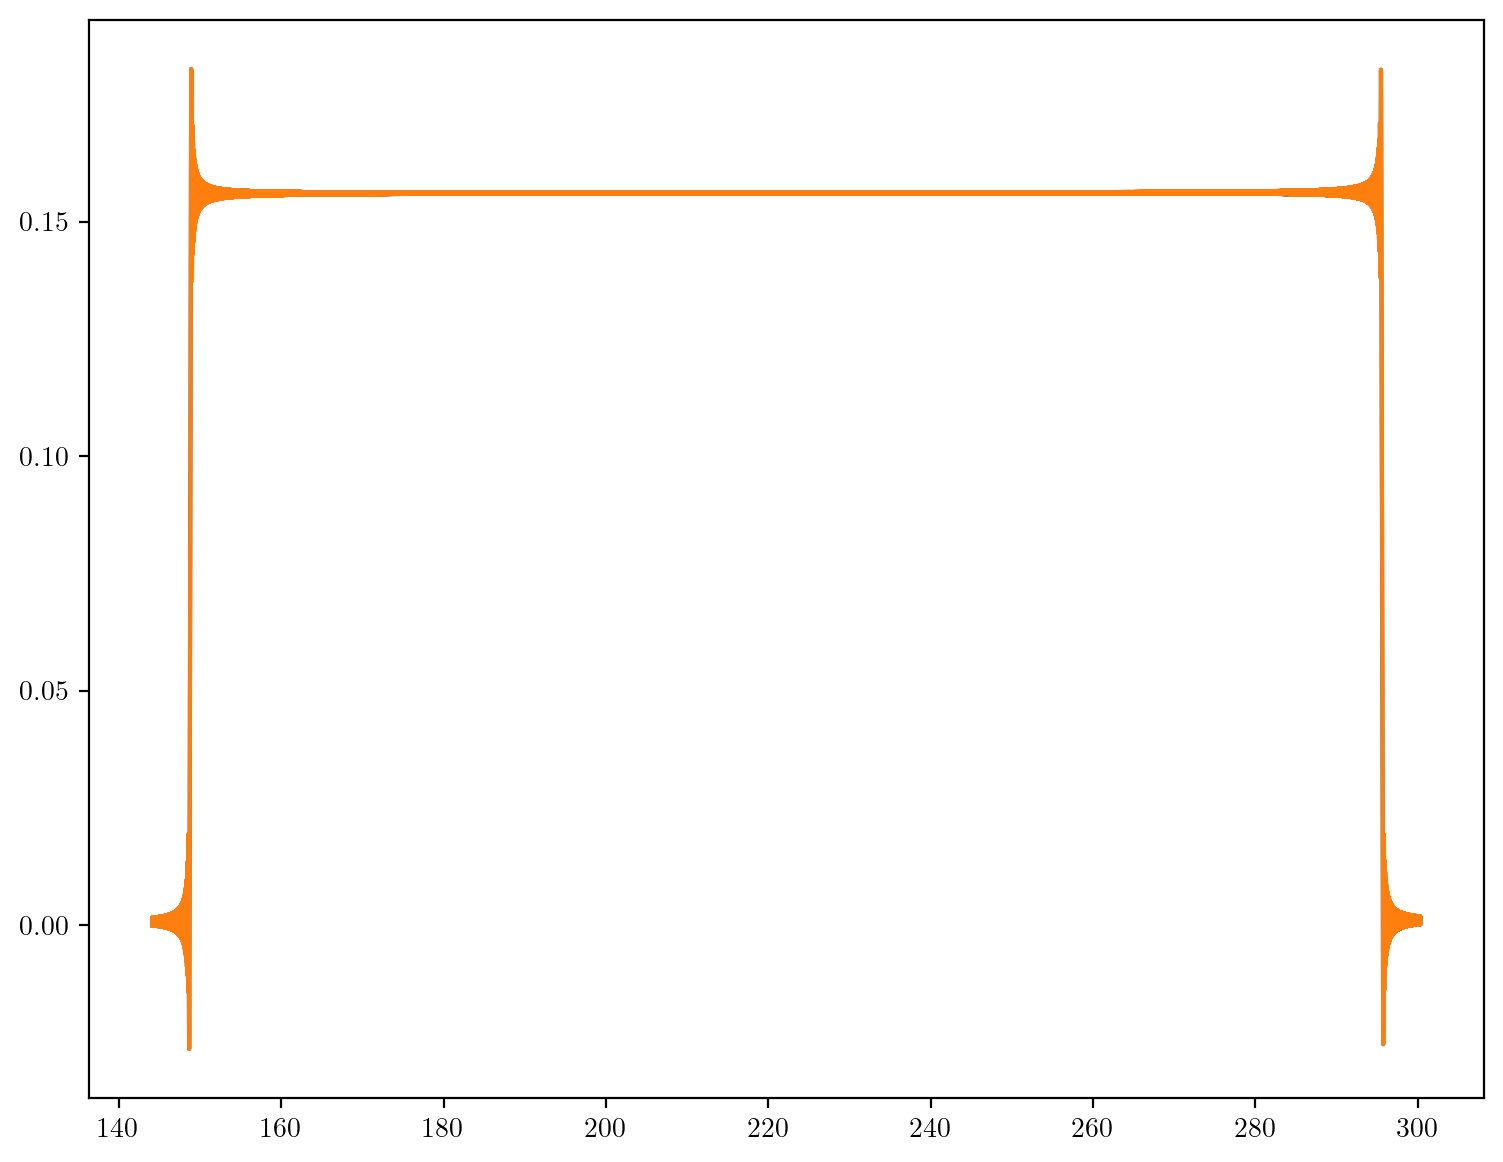

In [54]:
# Real part: 

plt.plot(z_tilde_thr_cut,sol_LZ_1_increasing_decreasing_u.y[0]* np.exp(-1j*phi_cumulative_cut/2))
plt.plot(z_tilde_thr_cut, sol_LZ_1_increasing_decreasing.y[0])

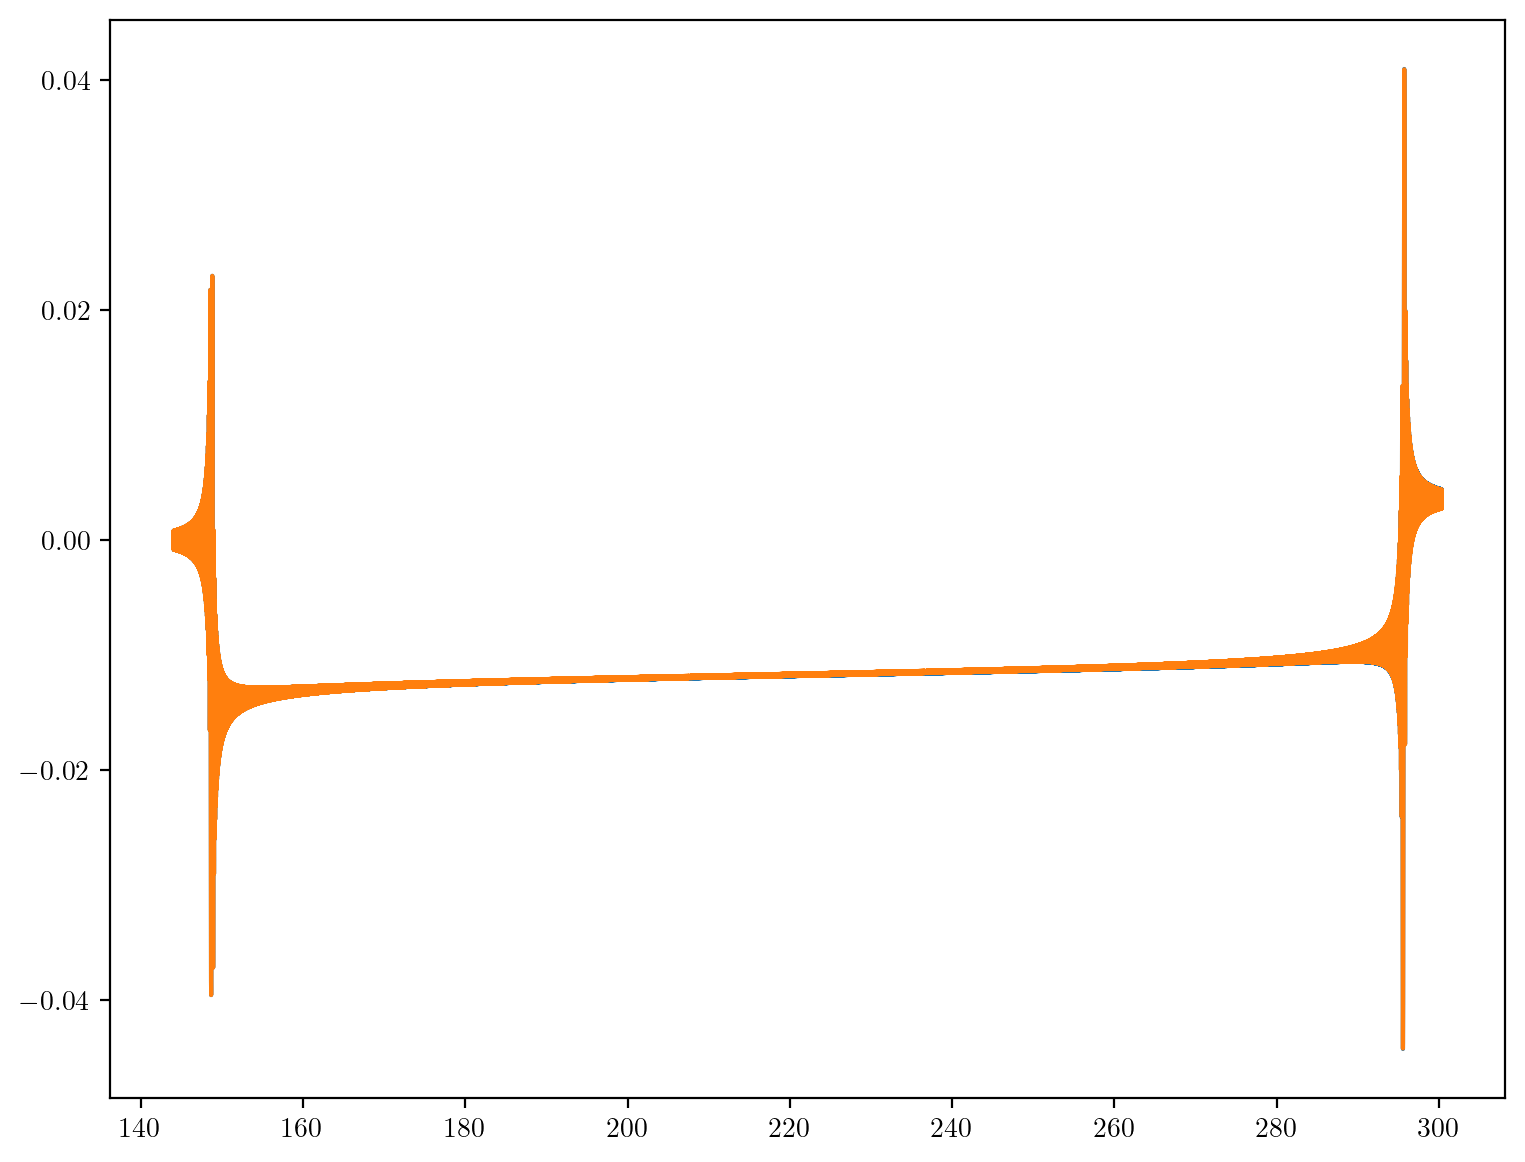

In [55]:
#Imaginary part

plt.plot(z_tilde_thr_cut, np.imag(sol_LZ_1_increasing_decreasing_u.y[0]* np.exp(-1j*phi_cumulative_cut/2)))
plt.plot(z_tilde_thr_cut, np.imag(sol_LZ_1_increasing_decreasing.y[0]))

## Test 3: why is the cut better using the WKB solution on $\ket{u}$ instead of $\ket{a}$? 

Text(0.5, 1.0, '$Im|a>$')

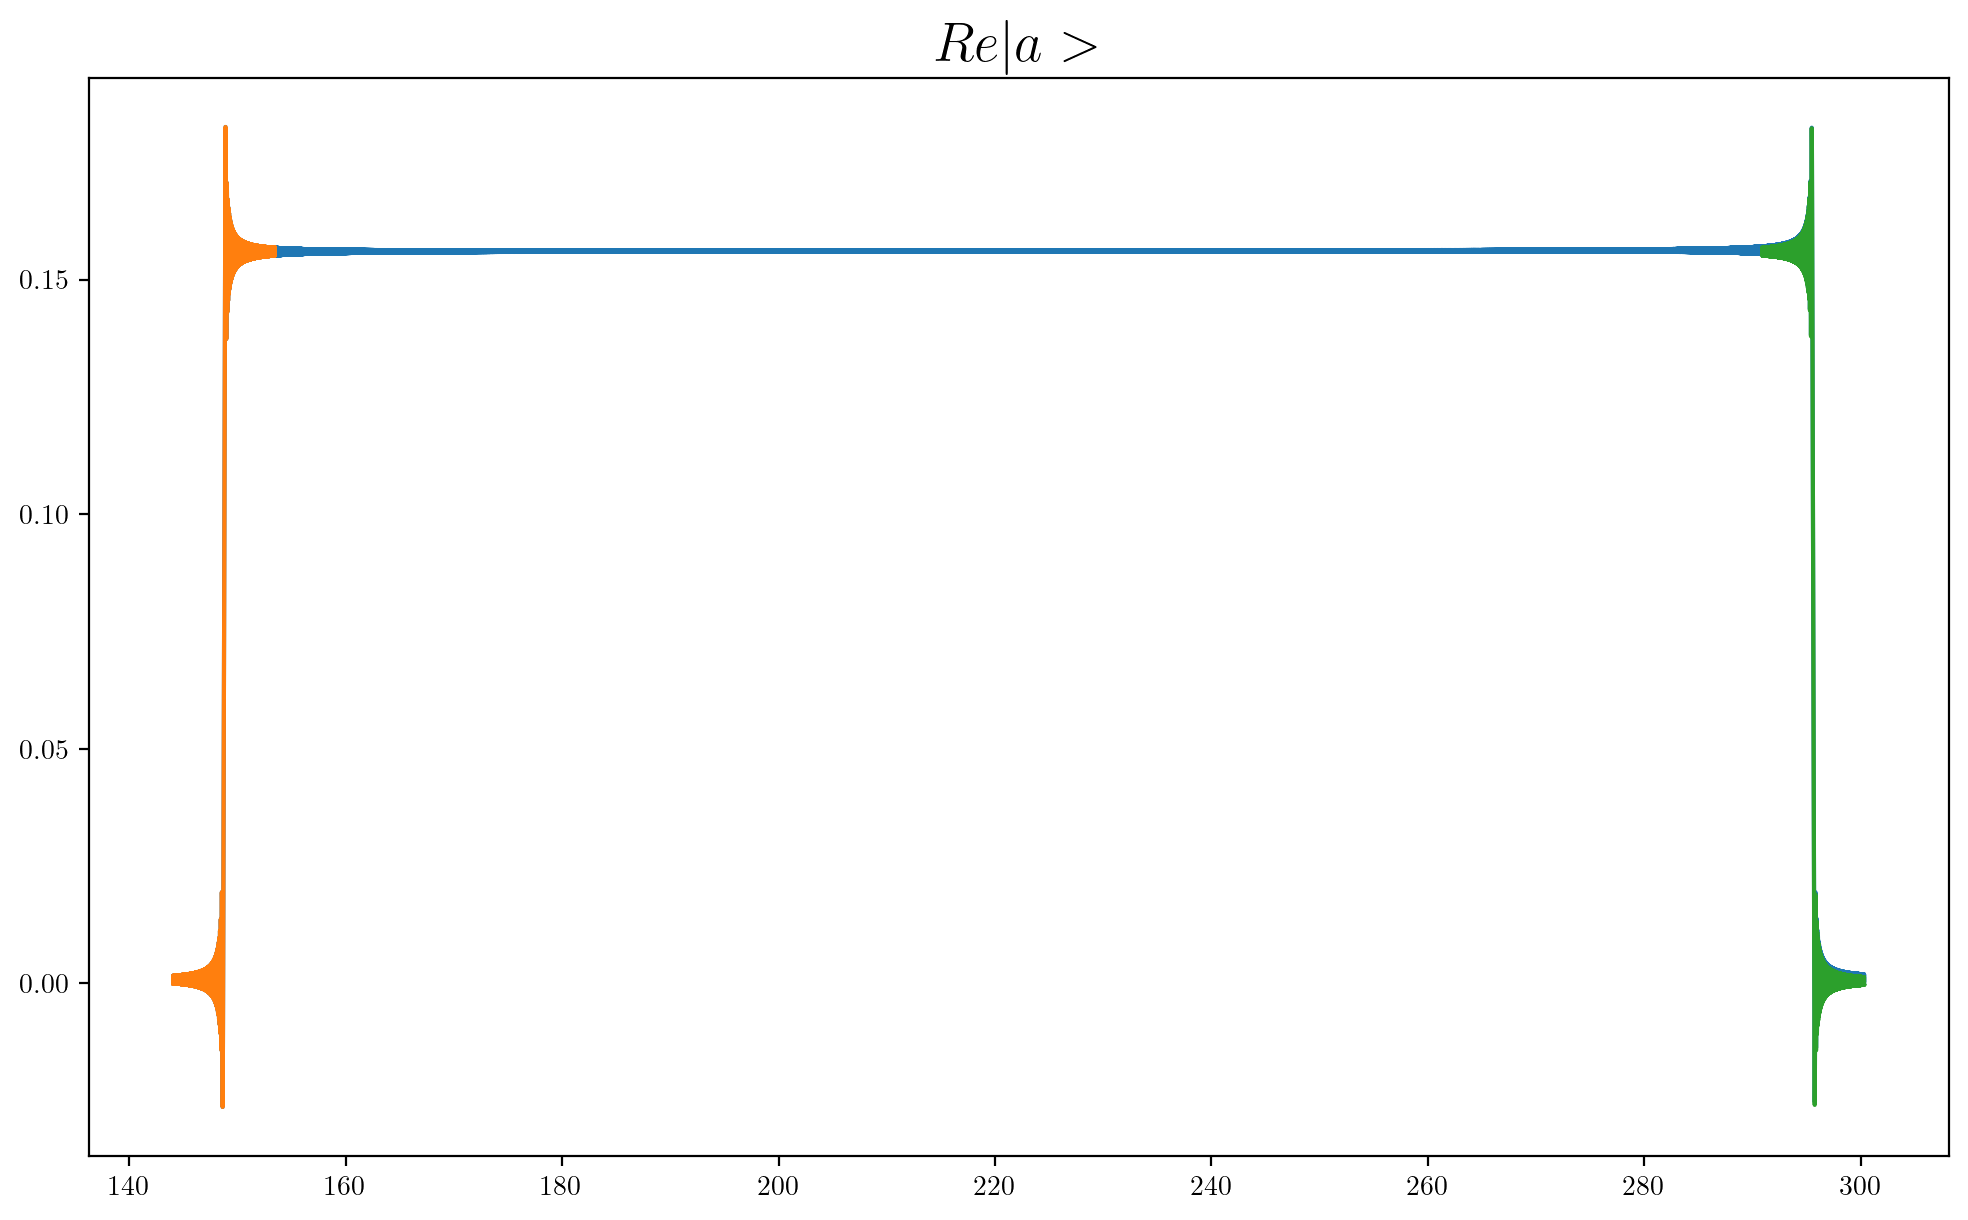

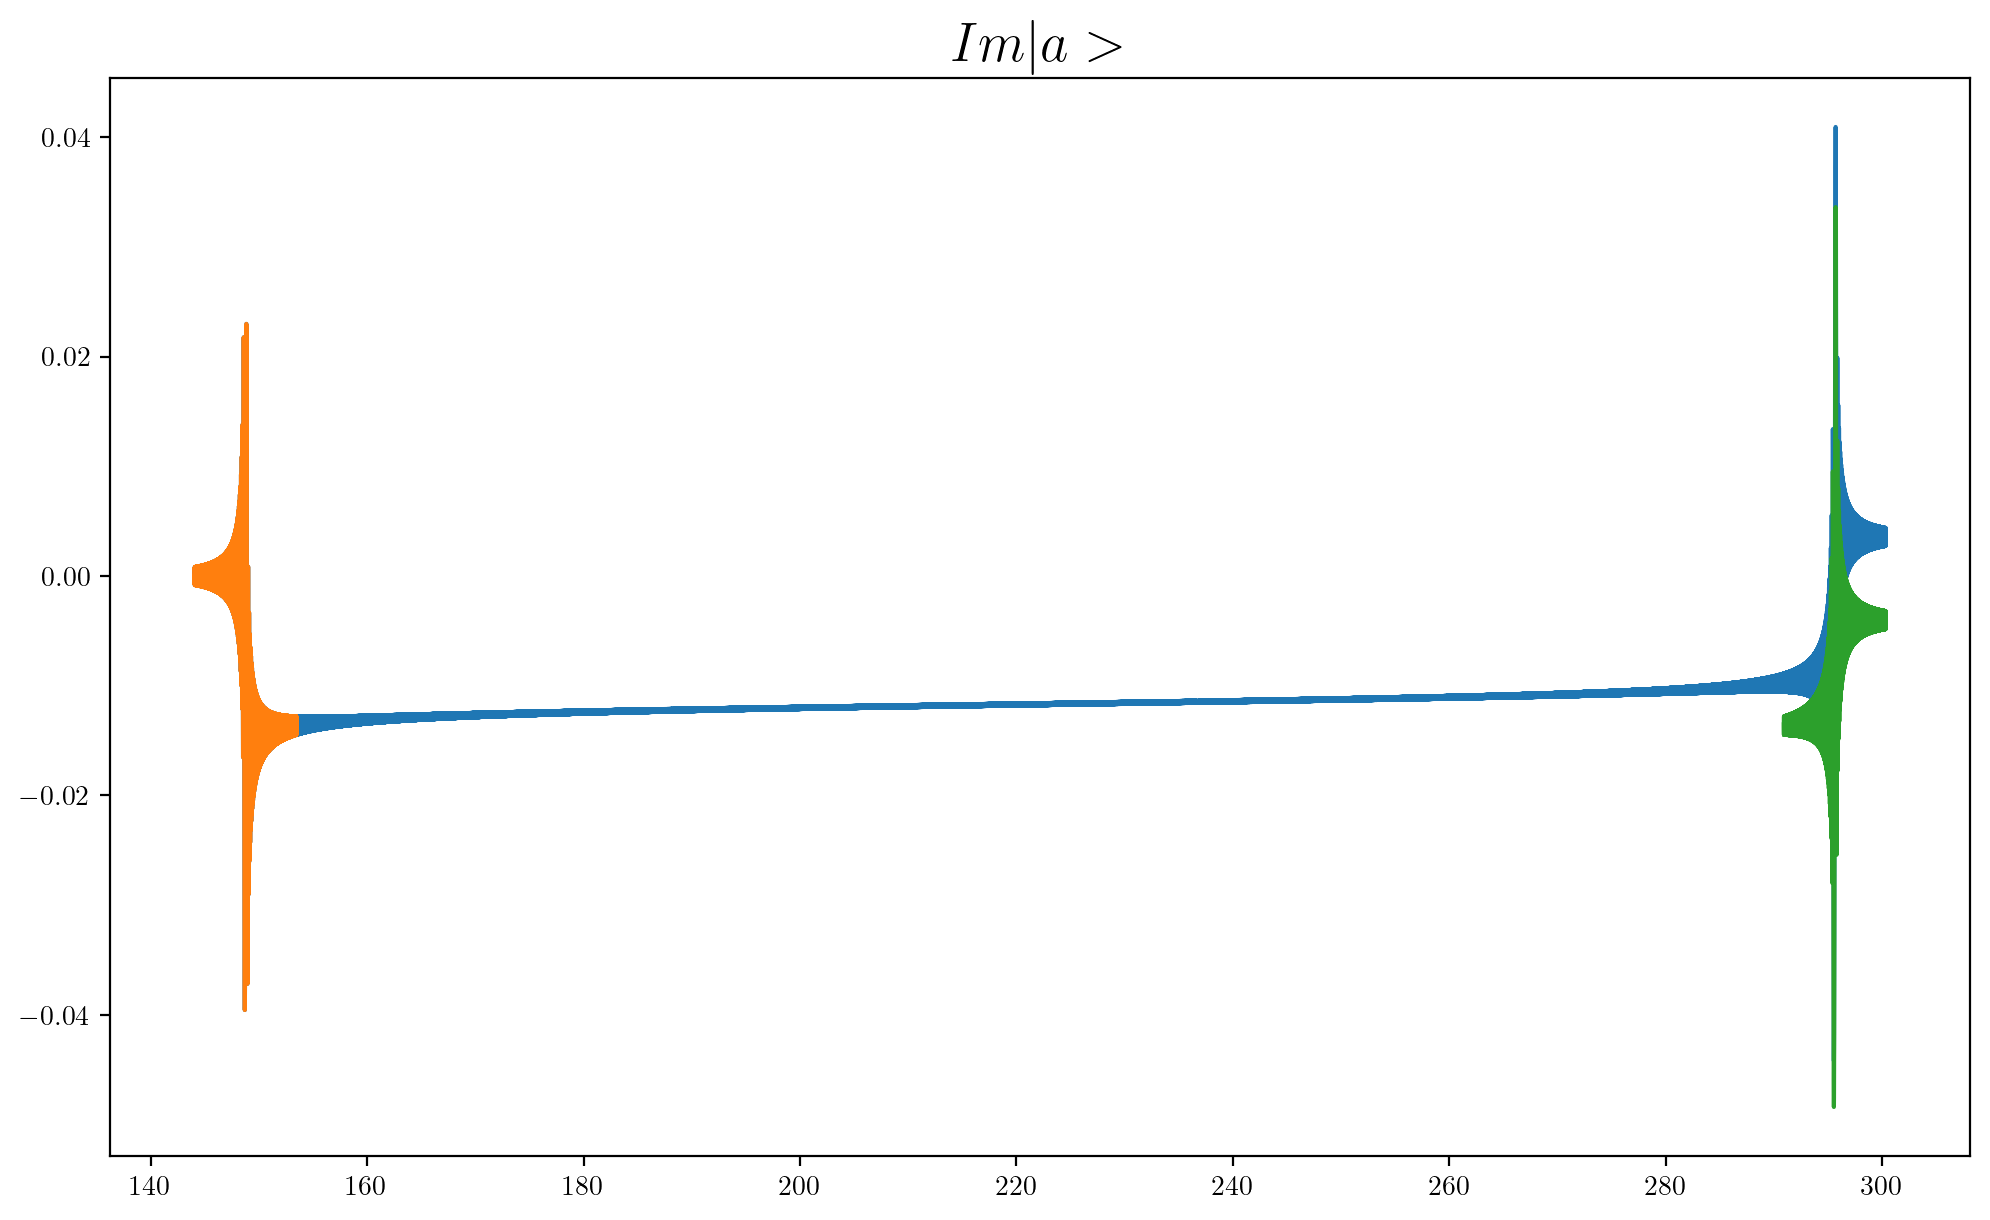

In [56]:
#######################################################
# Re|a> and Im|a> global vs cut
#######################################################


plt.figure(figsize=(12, 7))
plt.plot(z_tilde_thr_cut, sol_LZ_1_increasing_decreasing.y[0])
plt.plot(z_tilde_thr_cut1, sol_LZ_1_increasing_decreasing1.y[0])
plt.plot(z_tilde_thr_cut2, sol_LZ_1_increasing_decreasing2.y[0])
#plt.xlim(243,245)
plt.title('$Re|a>$', fontsize= '20')


plt.figure(figsize=(12, 7))
plt.plot(z_tilde_thr_cut, np.imag(sol_LZ_1_increasing_decreasing.y[0]))
plt.plot(z_tilde_thr_cut1, np.imag(sol_LZ_1_increasing_decreasing1.y[0]))
plt.plot(z_tilde_thr_cut2, np.imag(sol_LZ_1_increasing_decreasing2.y[0]))
#plt.xlim(243,245)
plt.title('$Im|a>$', fontsize= '20')


Text(0.5, 1.0, '$Im|u>$')

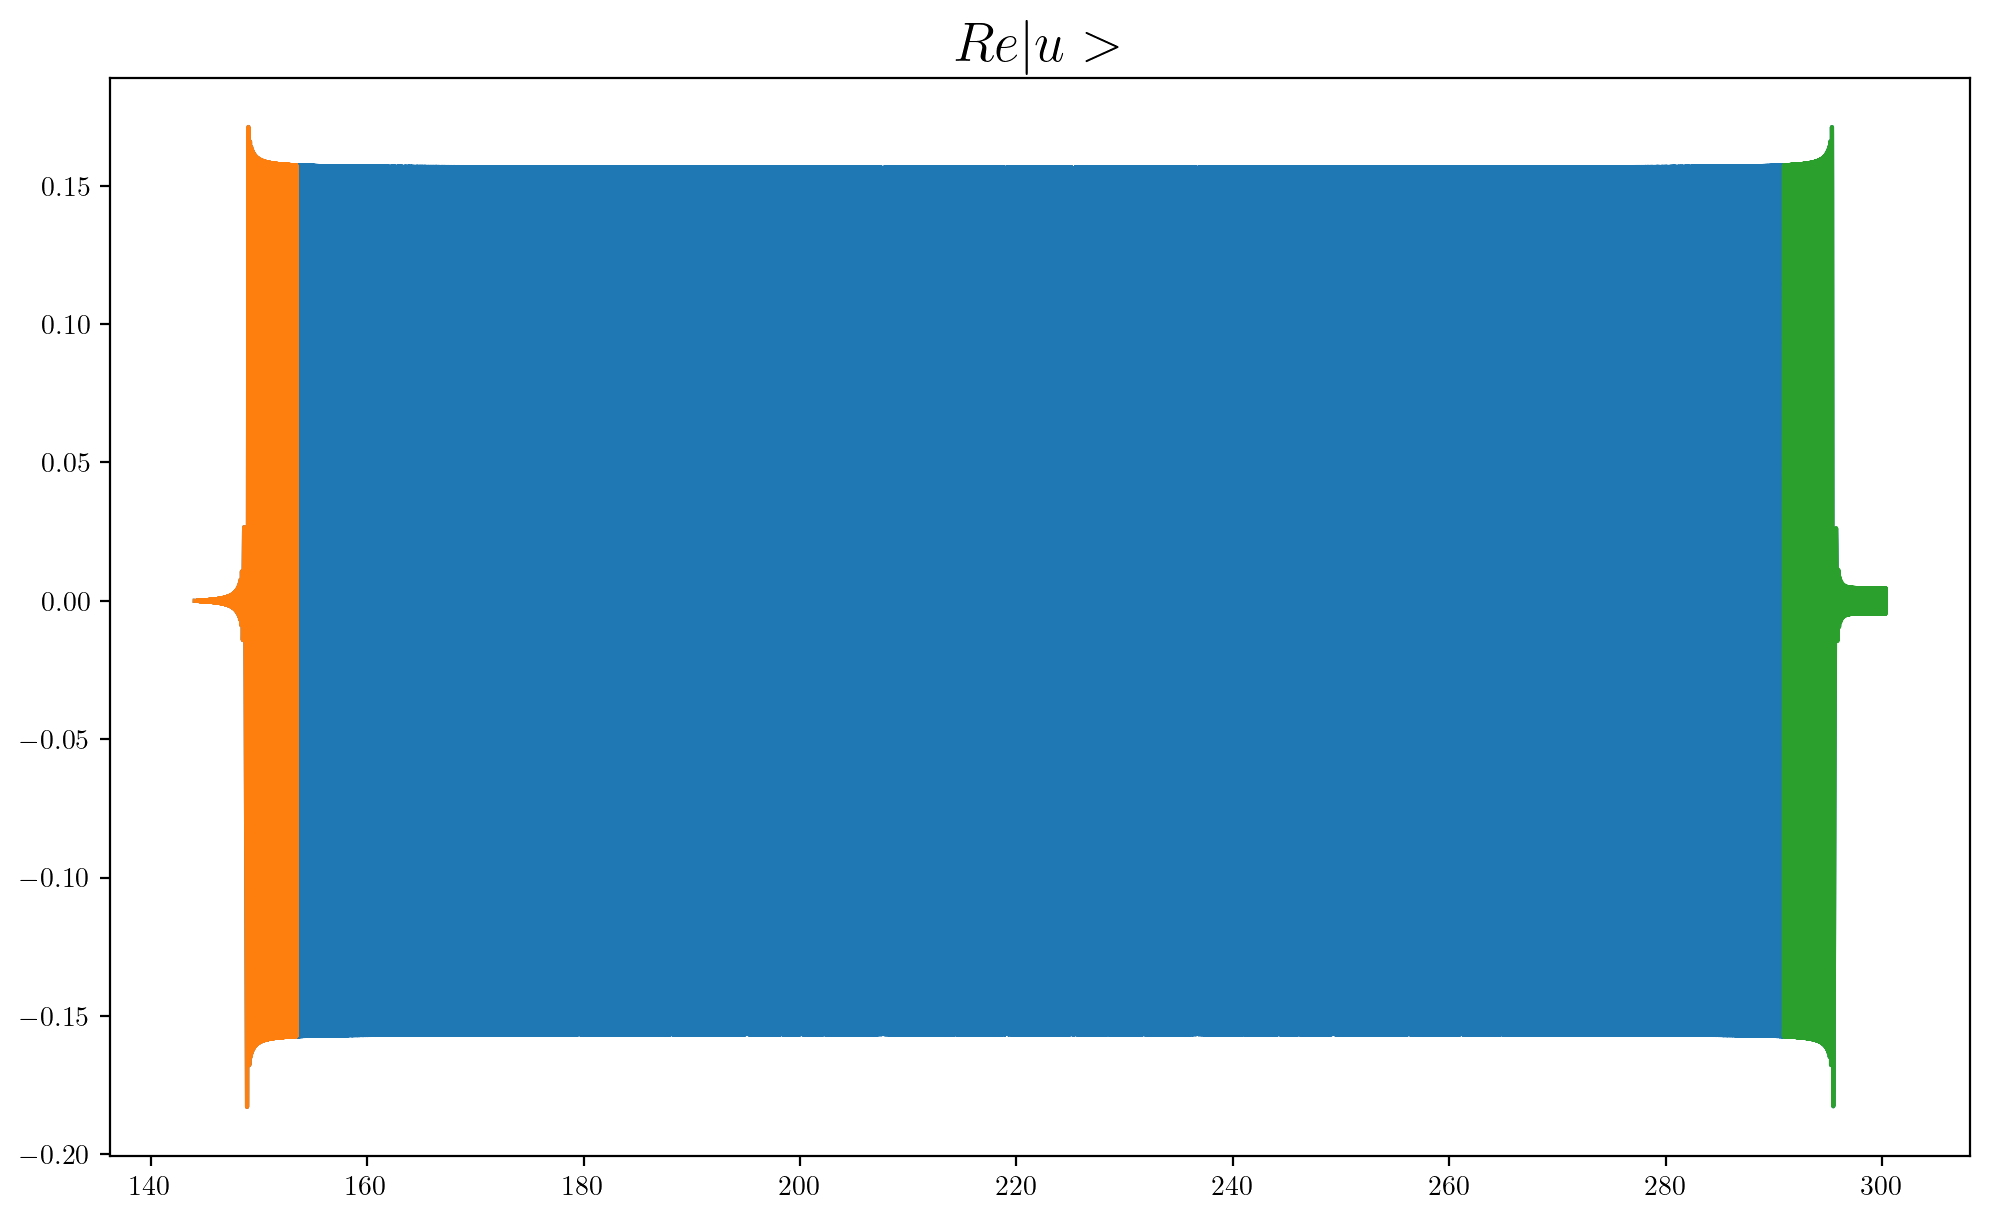

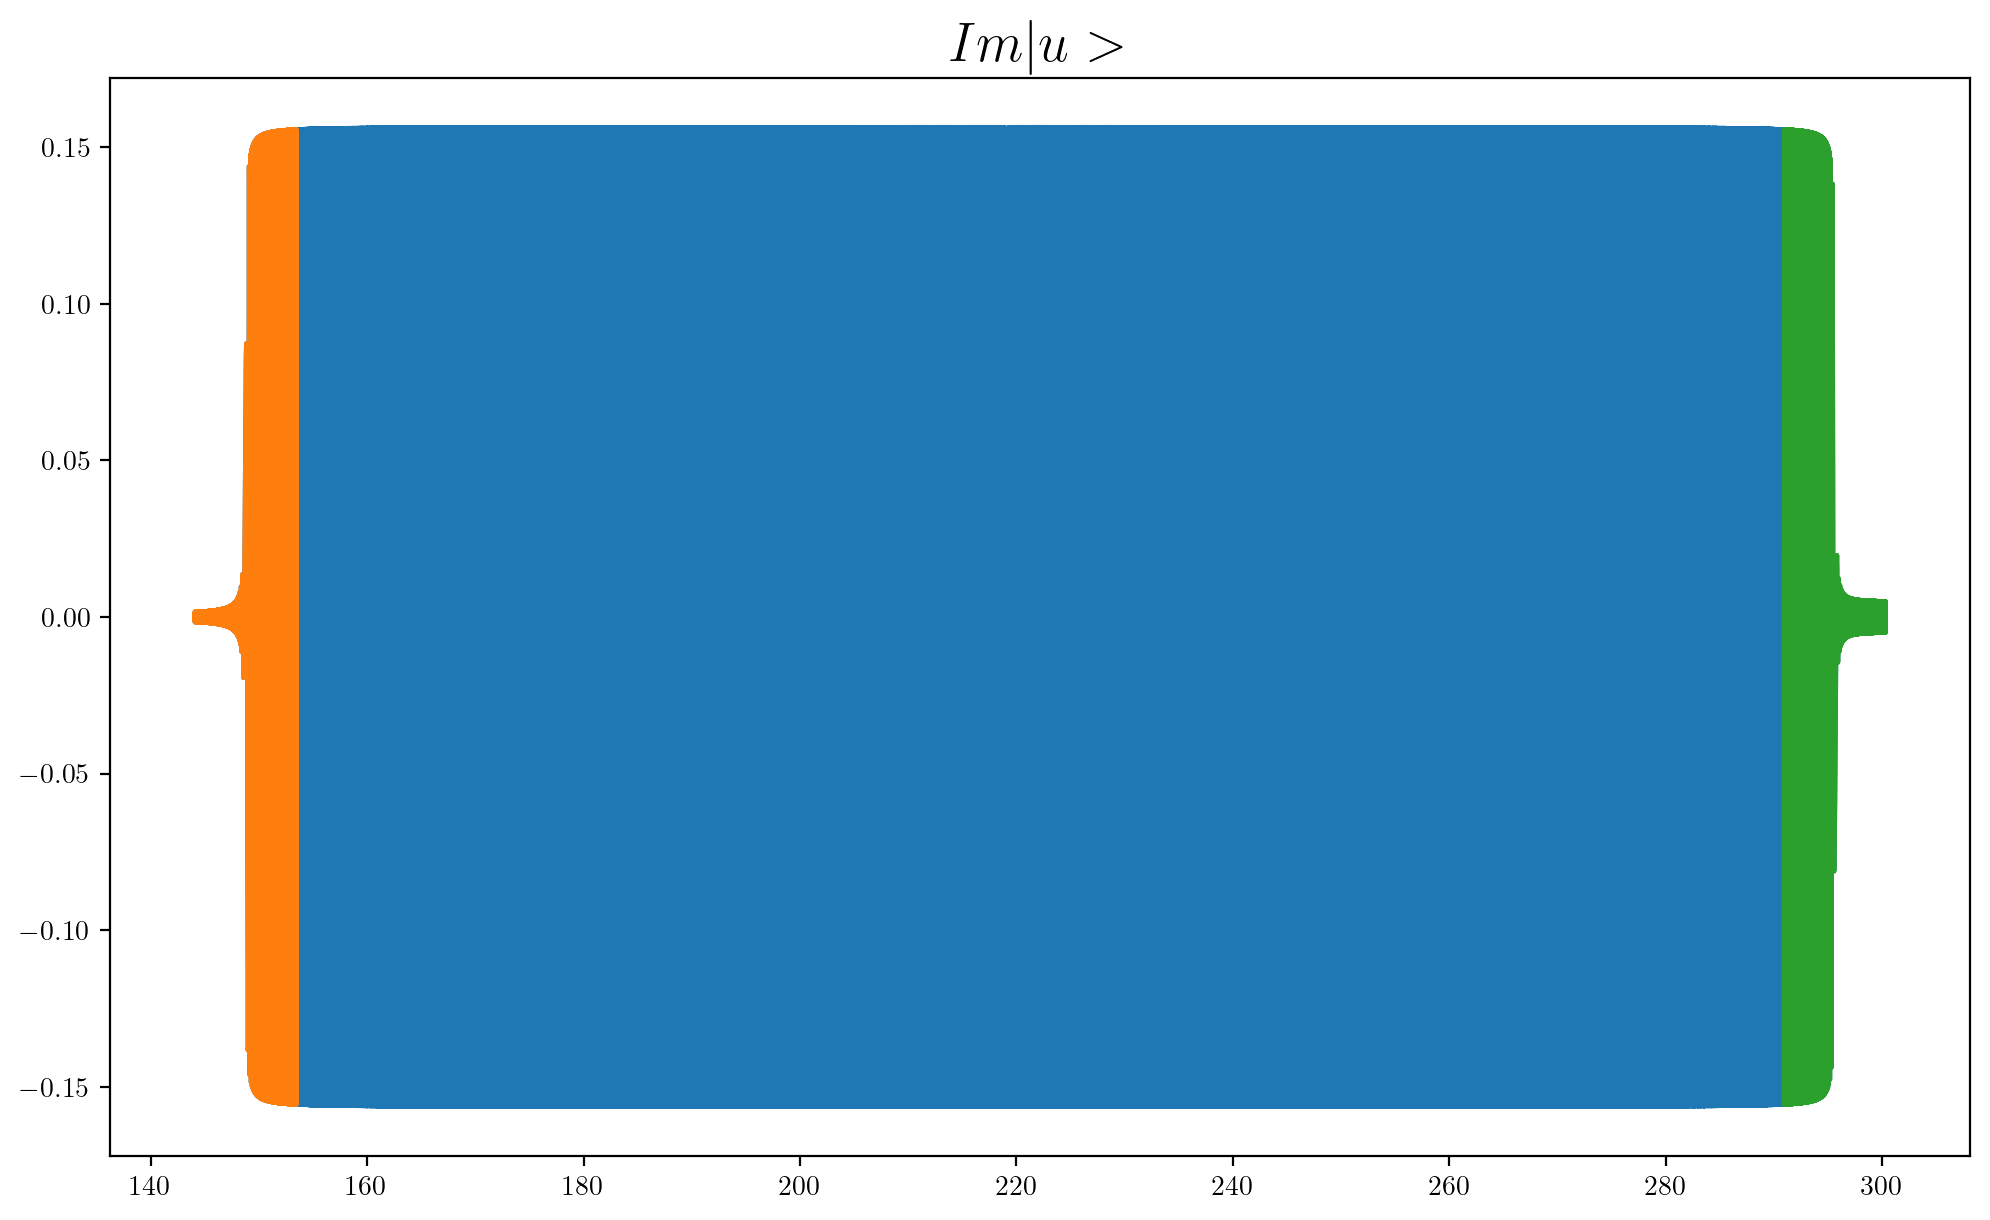

In [57]:
#######################################################
# Re|u> and Im|u> global vs cut
#######################################################


plt.figure(figsize=(12, 7))
plt.plot(z_tilde_thr_cut, sol_LZ_1_increasing_decreasing_u.y[0])
plt.plot(z_tilde_thr_cut1, sol_LZ_1_increasing_decreasing1_u.y[0])
plt.plot(z_tilde_thr_cut2, sol_LZ_1_increasing_decreasing2_u.y[0])
#plt.xlim(243,245)
plt.title('$Re|u>$', fontsize= '20')


plt.figure(figsize=(12, 7))
plt.plot(z_tilde_thr_cut, np.imag(sol_LZ_1_increasing_decreasing_u.y[0]))
plt.plot(z_tilde_thr_cut1, np.imag(sol_LZ_1_increasing_decreasing1_u.y[0]))
plt.plot(z_tilde_thr_cut2, np.imag(sol_LZ_1_increasing_decreasing2_u.y[0]))
#plt.xlim(243,245)
plt.title('$Im|u>$', fontsize= '20')

## Test 4: how the WKB implementation works better to match the value at $z_2^{min}$ 

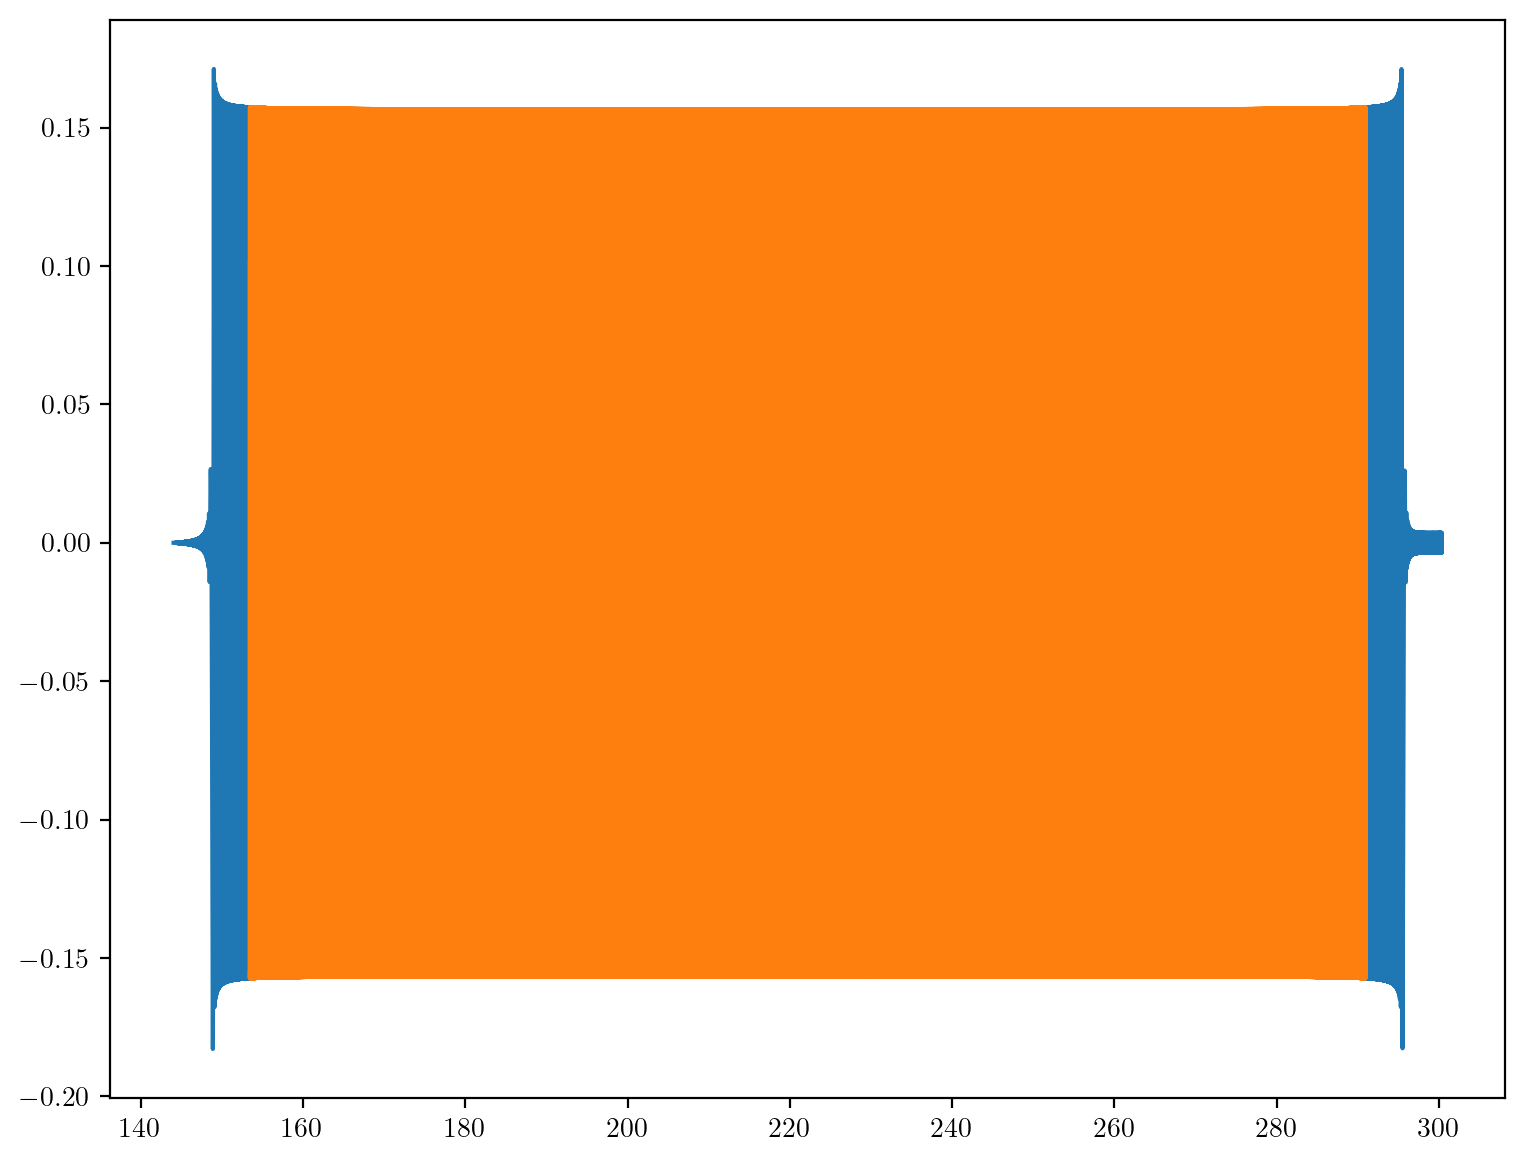

In [58]:
plt.plot(z_tilde_thr_cut, sol_LZ_1_increasing_decreasing_u.y[0])
plt.plot(z_grid, u_WKB)

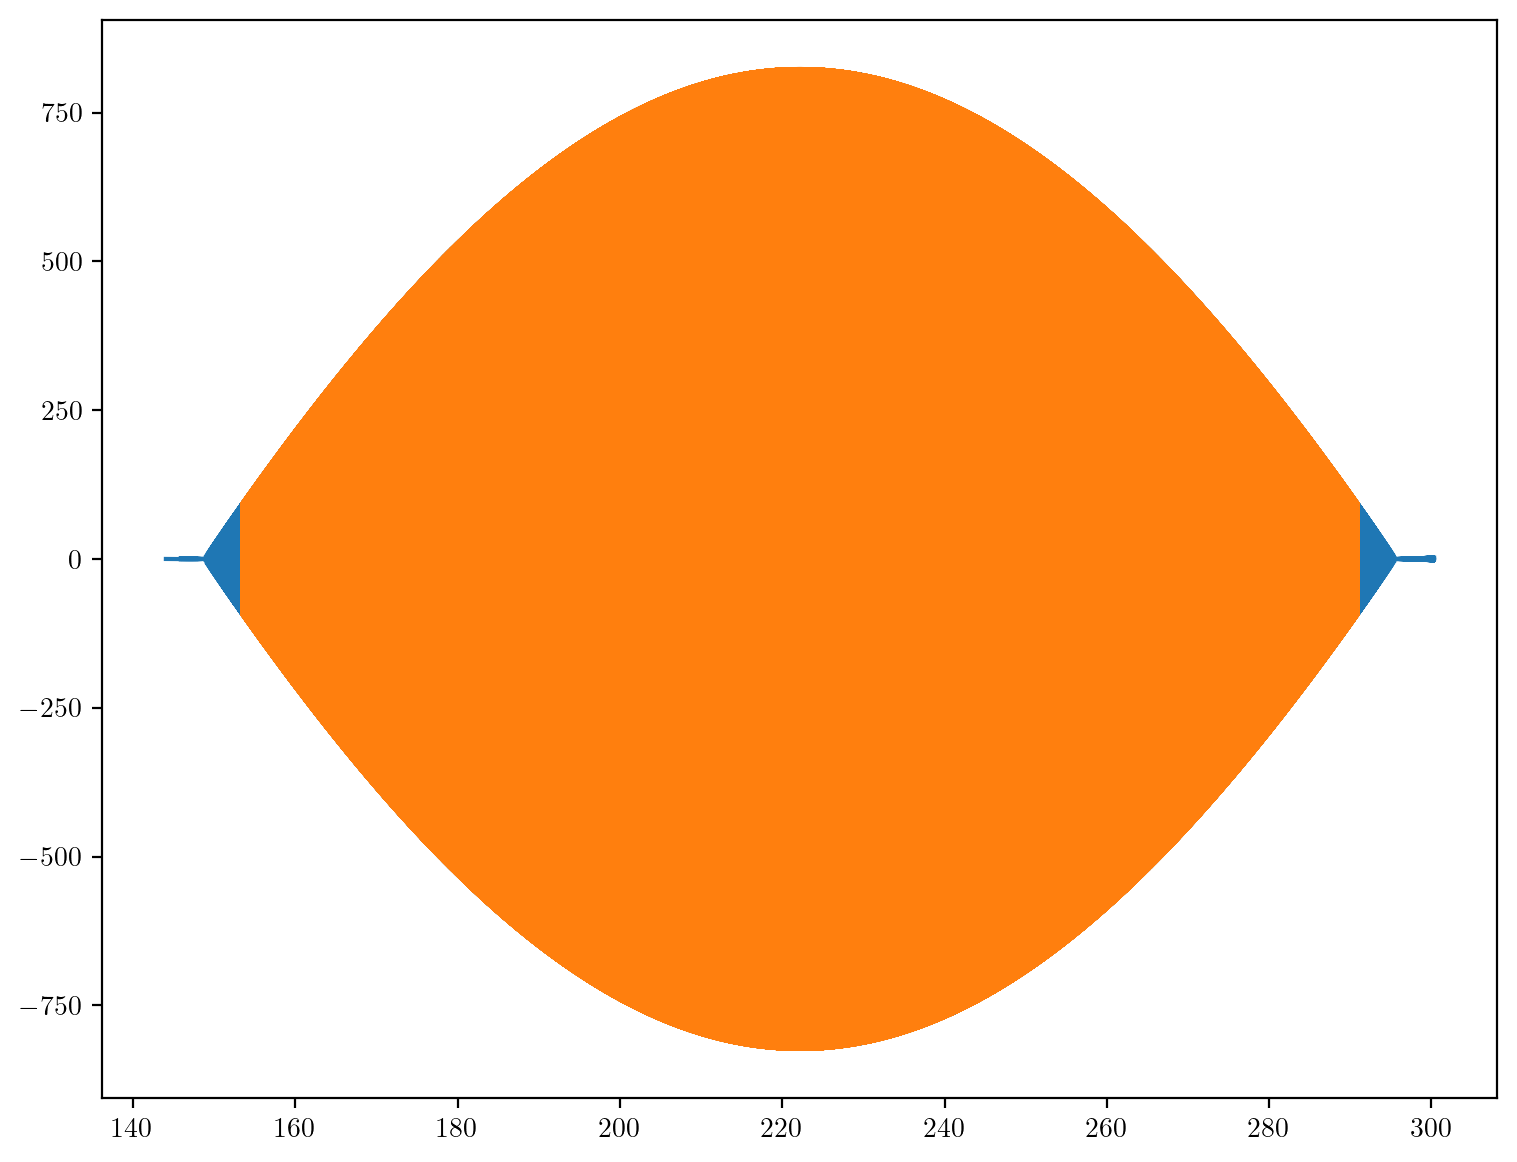

In [59]:
plt.plot(z_tilde_thr_cut, sol_LZ_1_increasing_decreasing_u.y[1])
plt.plot(z_grid, Du_WKB)